In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path
from matplotlib.colors import SymLogNorm

In [6]:
# https://jfly.uni-koeln.de/color/
# https://nanx.me/oneclust/reference/cud.html
named_colors = {
    "black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())
sns.set_theme(style="whitegrid")
HOM_THRESH = 5
def cud(n: int = len(cud_palette), start: int = 0) -> list[str]:
    remainder = cud_palette[:start]
    palette = cud_palette[start:] + remainder
    return palette[:n]

In [3]:
palette = {"TP": named_colors["blue"], "FP": named_colors["orange"], "FN": named_colors["vermilion"]}

In [4]:
df = pd.read_csv("../results/assess/mutref/annotations.csv", low_memory=False)
# create new column, indel_len, which is the absolute value of the difference in length between the ref and alt columns
df["indel_len"] = abs(df["ref"].str.len() - df["alt"].str.len())

In [5]:
frames = []
for p in Path("../results/assess/mutref").rglob("*.precision-recall.tsv"):
    _df = pd.read_csv(p, sep="\t")
    _df["sample"] = p.parent.name
    mask = "without" in p.name
    
    if "illumina" in str(p):
        caller = "illumina"
    else:
        caller = p.parts[-7]
        if caller != "clair3":
            continue
        dp = int(p.parts[-6][:-1])
        if dp < 100:
            continue
        mode = p.parts[-5]
        if mode == "duplex":
            continue
        model = p.parts[-3].split("_")[-1].split("@")[0]
        if model != "sup":
            continue
    _df["mask_repeats"] = mask
    _df["caller"] = caller
    frames.append(_df)

mask_df = pd.concat(frames)
mask_df.reset_index(inplace=True)

In [185]:
mask_df

,index,VAR_TYPE,MIN_QUAL,PREC,RECALL,F1_SCORE,F1_QSCORE,TRUTH_TOTAL,TRUTH_TP,TRUTH_FN,QUERY_TOTAL,QUERY_TP,QUERY_FP,sample,mask_repeats,caller
0,0,SNP,0,1.0,1.000000,1.000000,100.00000,2102,2102,0,2102,2102,0,AMtb_1__202402,False,clair3
1,1,SNP,1,1.0,1.000000,1.000000,100.00000,2102,2102,0,2102,2102,0,AMtb_1__202402,False,clair3
2,2,SNP,2,1.0,1.000000,1.000000,100.00000,2102,2102,0,2102,2102,0,AMtb_1__202402,False,clair3
3,3,SNP,3,1.0,1.000000,1.000000,100.00000,2102,2102,0,2102,2102,0,AMtb_1__202402,False,clair3
4,4,SNP,4,1.0,1.000000,1.000000,100.00000,2102,2102,0,2102,2102,0,AMtb_1__202402,False,clair3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389523,82083,ALL,20517,1.0,0.000017,0.000034,0.00015,58100,1,58099,1,1,0,ATCC_17802__202309,True,illumina
1389524,82084,ALL,20518,1.0,0.000017,0.000034,0.00015,58100,1,58099,1,1,0,ATCC_17802__202309,True,illumina
1389525,82085,ALL,20519,1.0,0.000017,0.000034,0.00015,58100,1,58099,1,1,0,ATCC_17802__202309,True,illumina
1389526,82086,ALL,20520,1.0,0.000017,0.000034,0.00015,58100,1,58099,1,1,0,ATCC_17802__202309,True,illumina


In [229]:
dataix = (
    mask_df.query("VAR_TYPE == 'ALL'")
    .groupby(["sample", "caller", "mask_repeats"])["F1_SCORE"]
    .idxmax()
)
best_mask = mask_df.iloc[dataix]

In [230]:
best_mask

,index,VAR_TYPE,MIN_QUAL,PREC,RECALL,F1_SCORE,F1_QSCORE,TRUTH_TOTAL,TRUTH_TP,TRUTH_FN,QUERY_TOTAL,QUERY_TP,QUERY_FP,sample,mask_repeats,caller
10989,333,ALL,0,1.000000,0.999957,0.999978,46.636185,23043,23042,1,23042,23042,0,AJ292__202310,False,clair3
11433,333,ALL,0,1.000000,0.999956,0.999978,46.553459,22605,22604,1,22604,22604,0,AJ292__202310,True,clair3
1187409,22817,ALL,32,0.999126,0.991972,0.995536,23.502613,23043,22858,185,22878,22858,20,AJ292__202310,False,illumina
1217856,22884,ALL,99,0.999646,0.999248,0.999447,32.571720,22605,22588,17,22596,22588,8,AJ292__202310,True,illumina
333,333,ALL,0,1.000000,0.999562,0.999781,36.591084,2281,2280,1,2280,2280,0,AMtb_1__202402,False,clair3
777,333,ALL,0,1.000000,1.000000,1.000000,100.000000,2027,2027,0,2027,2027,0,AMtb_1__202402,True,clair3
35917,23485,ALL,46,0.995960,0.972819,0.984254,18.028215,2281,2219,62,2228,2219,9,AMtb_1__202402,False,illumina
67135,23451,ALL,12,0.995520,0.986680,0.991080,20.496490,2027,2000,27,2009,2000,9,AMtb_1__202402,True,illumina
4329,333,ALL,0,0.999948,0.999739,0.999844,38.057560,19183,19178,5,19172,19171,1,ATCC_10708__202309,False,clair3
3885,333,ALL,0,0.999946,0.999729,0.999837,37.887165,18439,18434,5,18428,18427,1,ATCC_10708__202309,True,clair3


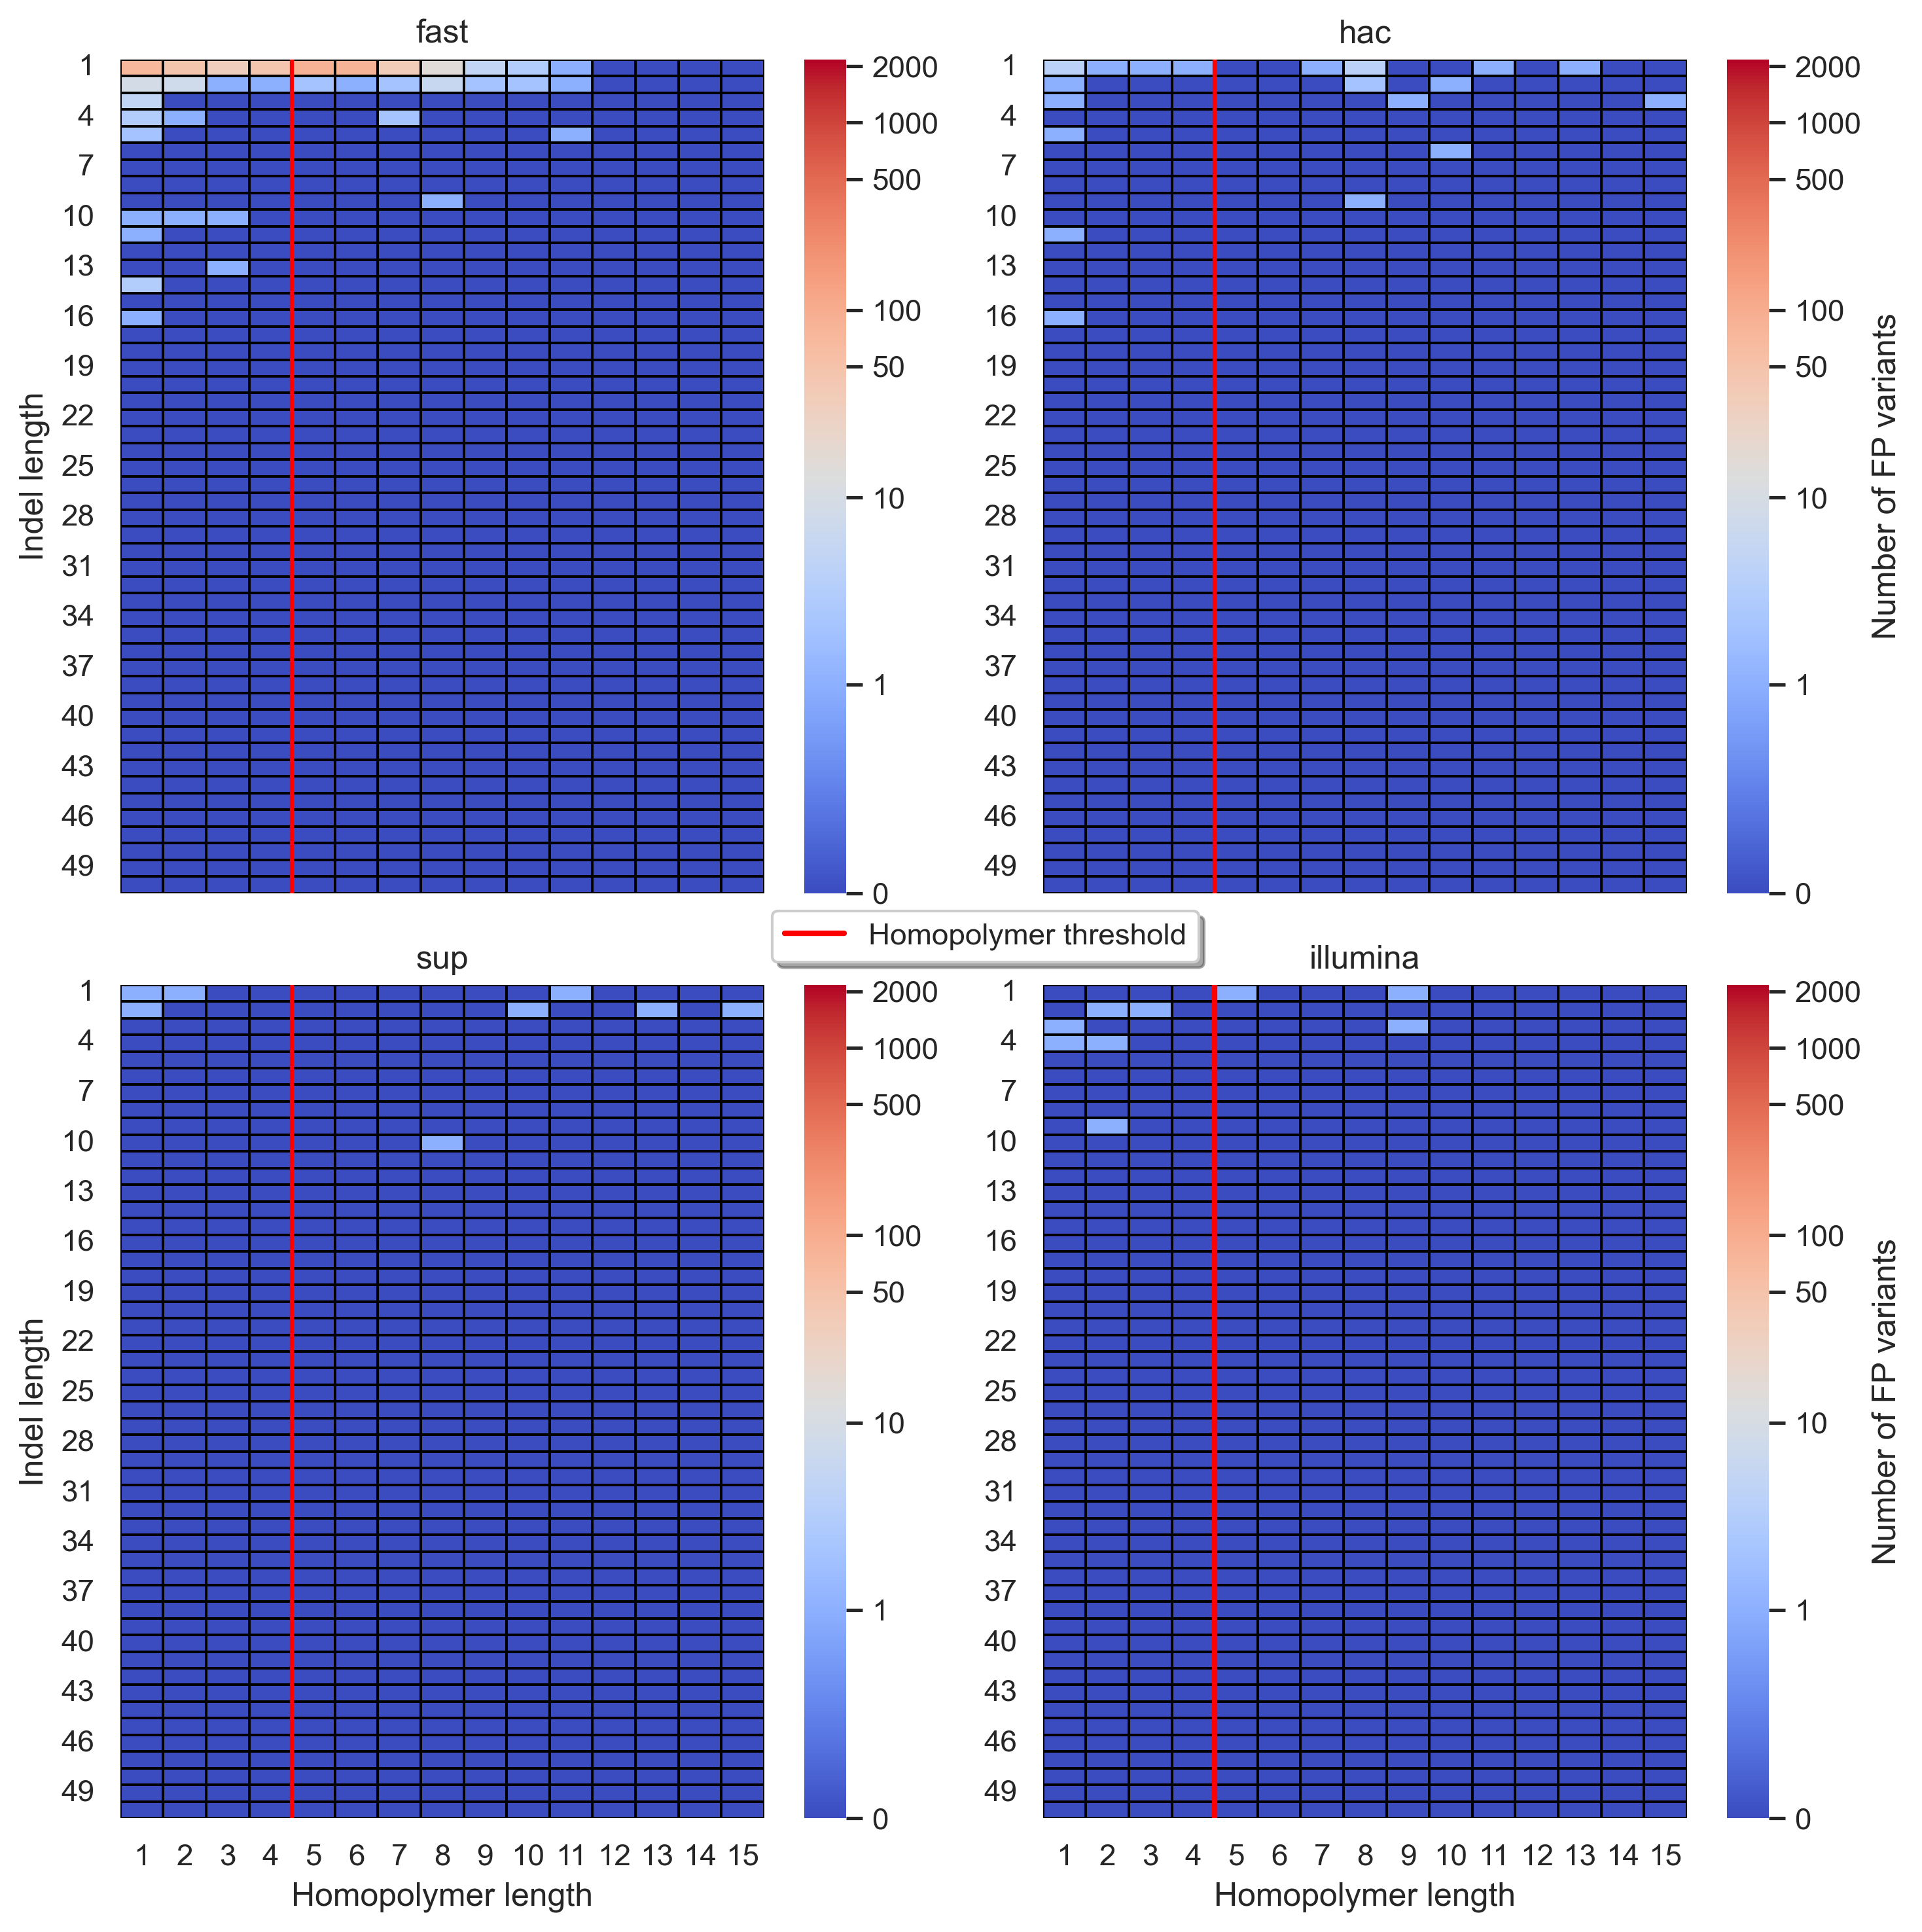

In [26]:
# create a heatmap of the indel_len vs. homlen columns
caller = "clair3"
max_indel_len = df.query("vartype=='INDEL' and mode == 'simplex' and caller==@caller")["indel_len"].max()
max_homlen = df.query("vartype=='INDEL' and mode == 'simplex' and caller==@caller")["homlen"].max()
# set vmin and vmax to the min and max of the number of FP variants
vmax = (
    df.query("vartype=='INDEL' and mode == 'simplex' and decision == 'FP'")
    .groupby(["caller", "model", "homlen", "indel_len"])
    .count()["sample"]
    .max()
)
vmin = 0

fig, axes = plt.subplots(figsize=(10, 10), dpi=300, nrows=2, ncols=2, sharex=True)
# cbar_ax = fig.add_axes([1.0, 0.1, 0.03, 0.8])
for i, model in enumerate(["fast", "hac", "sup", "illumina"]):
    ax = axes.flatten()[i]
    if model == "illumina":
        data = df.query("caller == 'illumina'")
    else:
        data = df.query("caller == @caller")
        data = data.query("model == @model and mode == 'simplex'")
    data = data.query("vartype == 'INDEL' and decision == 'FP'")

    HOM_THRESH = 5
    # data = data.query(f"homlen >= {HOM_THRESH}")
    x = "indel_len"
    y = "homlen"
    # turn data into a pivot table where the cells are the counts of the number of variants
    # in each bin
    pivot = data.pivot_table(index=x, columns=y, aggfunc="size", fill_value=0)
    total_fps = data.query("decision == 'FP'").shape[0]
    # calculate the percentage of the total number of FP variants in each bin
    # pivot = pivot / total_fps * 100
    # fill in the missing columns and rows
    for j in range(1, max_indel_len + 1):
        if j not in pivot.index:
            pivot.loc[j] = 0
    for j in range(1, max_homlen + 1):
        if j not in pivot.columns:
            pivot[j] = 0
    pivot.sort_index(axis=0, inplace=True)
    pivot.sort_index(axis=1, inplace=True)

    # create a heatmap of the pivot table
    mask = pivot == 0

    fmt = "d"
    cbar_ticks = [0, 1, 10, 50, 100, 500, 1000, 2000]
    cbar_kws = {
        "ticks": cbar_ticks,
        "format": mticker.FixedFormatter(cbar_ticks),
        "label": "Number of FP variants"  if i in [1,3] else "",
    }
    sns.heatmap(
        pivot,
        ax=ax,
        cmap="coolwarm",
        cbar_kws=cbar_kws,
        # square=True,
        # annot=True,
        linecolor="black",
        linewidths=0.5,
        cbar=True,
        fmt=fmt,
        # mask=mask,
        # vmin=vmin,
        # vmax=vmax,
        norm=SymLogNorm(vmax=vmax, linthresh=1),
    )
    ax.set_title(model)
    if i < 2:
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Homopolymer length")
    if i in [1, 3]:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Indel length")

    # turn off gridlines
    ax.grid(False)

    # add a vertical dashed line at the HOM_THRESH and align to left

    ax.axvline(
        HOM_THRESH - 1,
        color="red",
        linestyle="-",
        snap=True,
        label="Homopolymer threshold",
    )
    # fill between 0 and HOM_THRESH
    # ax.fill_between(
    #     [0, HOM_THRESH - 1],
    #     0,
    #     df["indel_len"].max(),
    #     color="red",
    #     alpha=0.1,
    # )
    # rotate yticklabels
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    # rotate xticklabels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


fig.tight_layout()
handles, labels = ax.get_legend_handles_labels()
for h in handles:
    h.set_linewidth(2)
fig.legend(handles=handles, labels=labels, loc="center", fancybox=True, shadow=True, bbox_to_anchor=(0.51, 0.515))

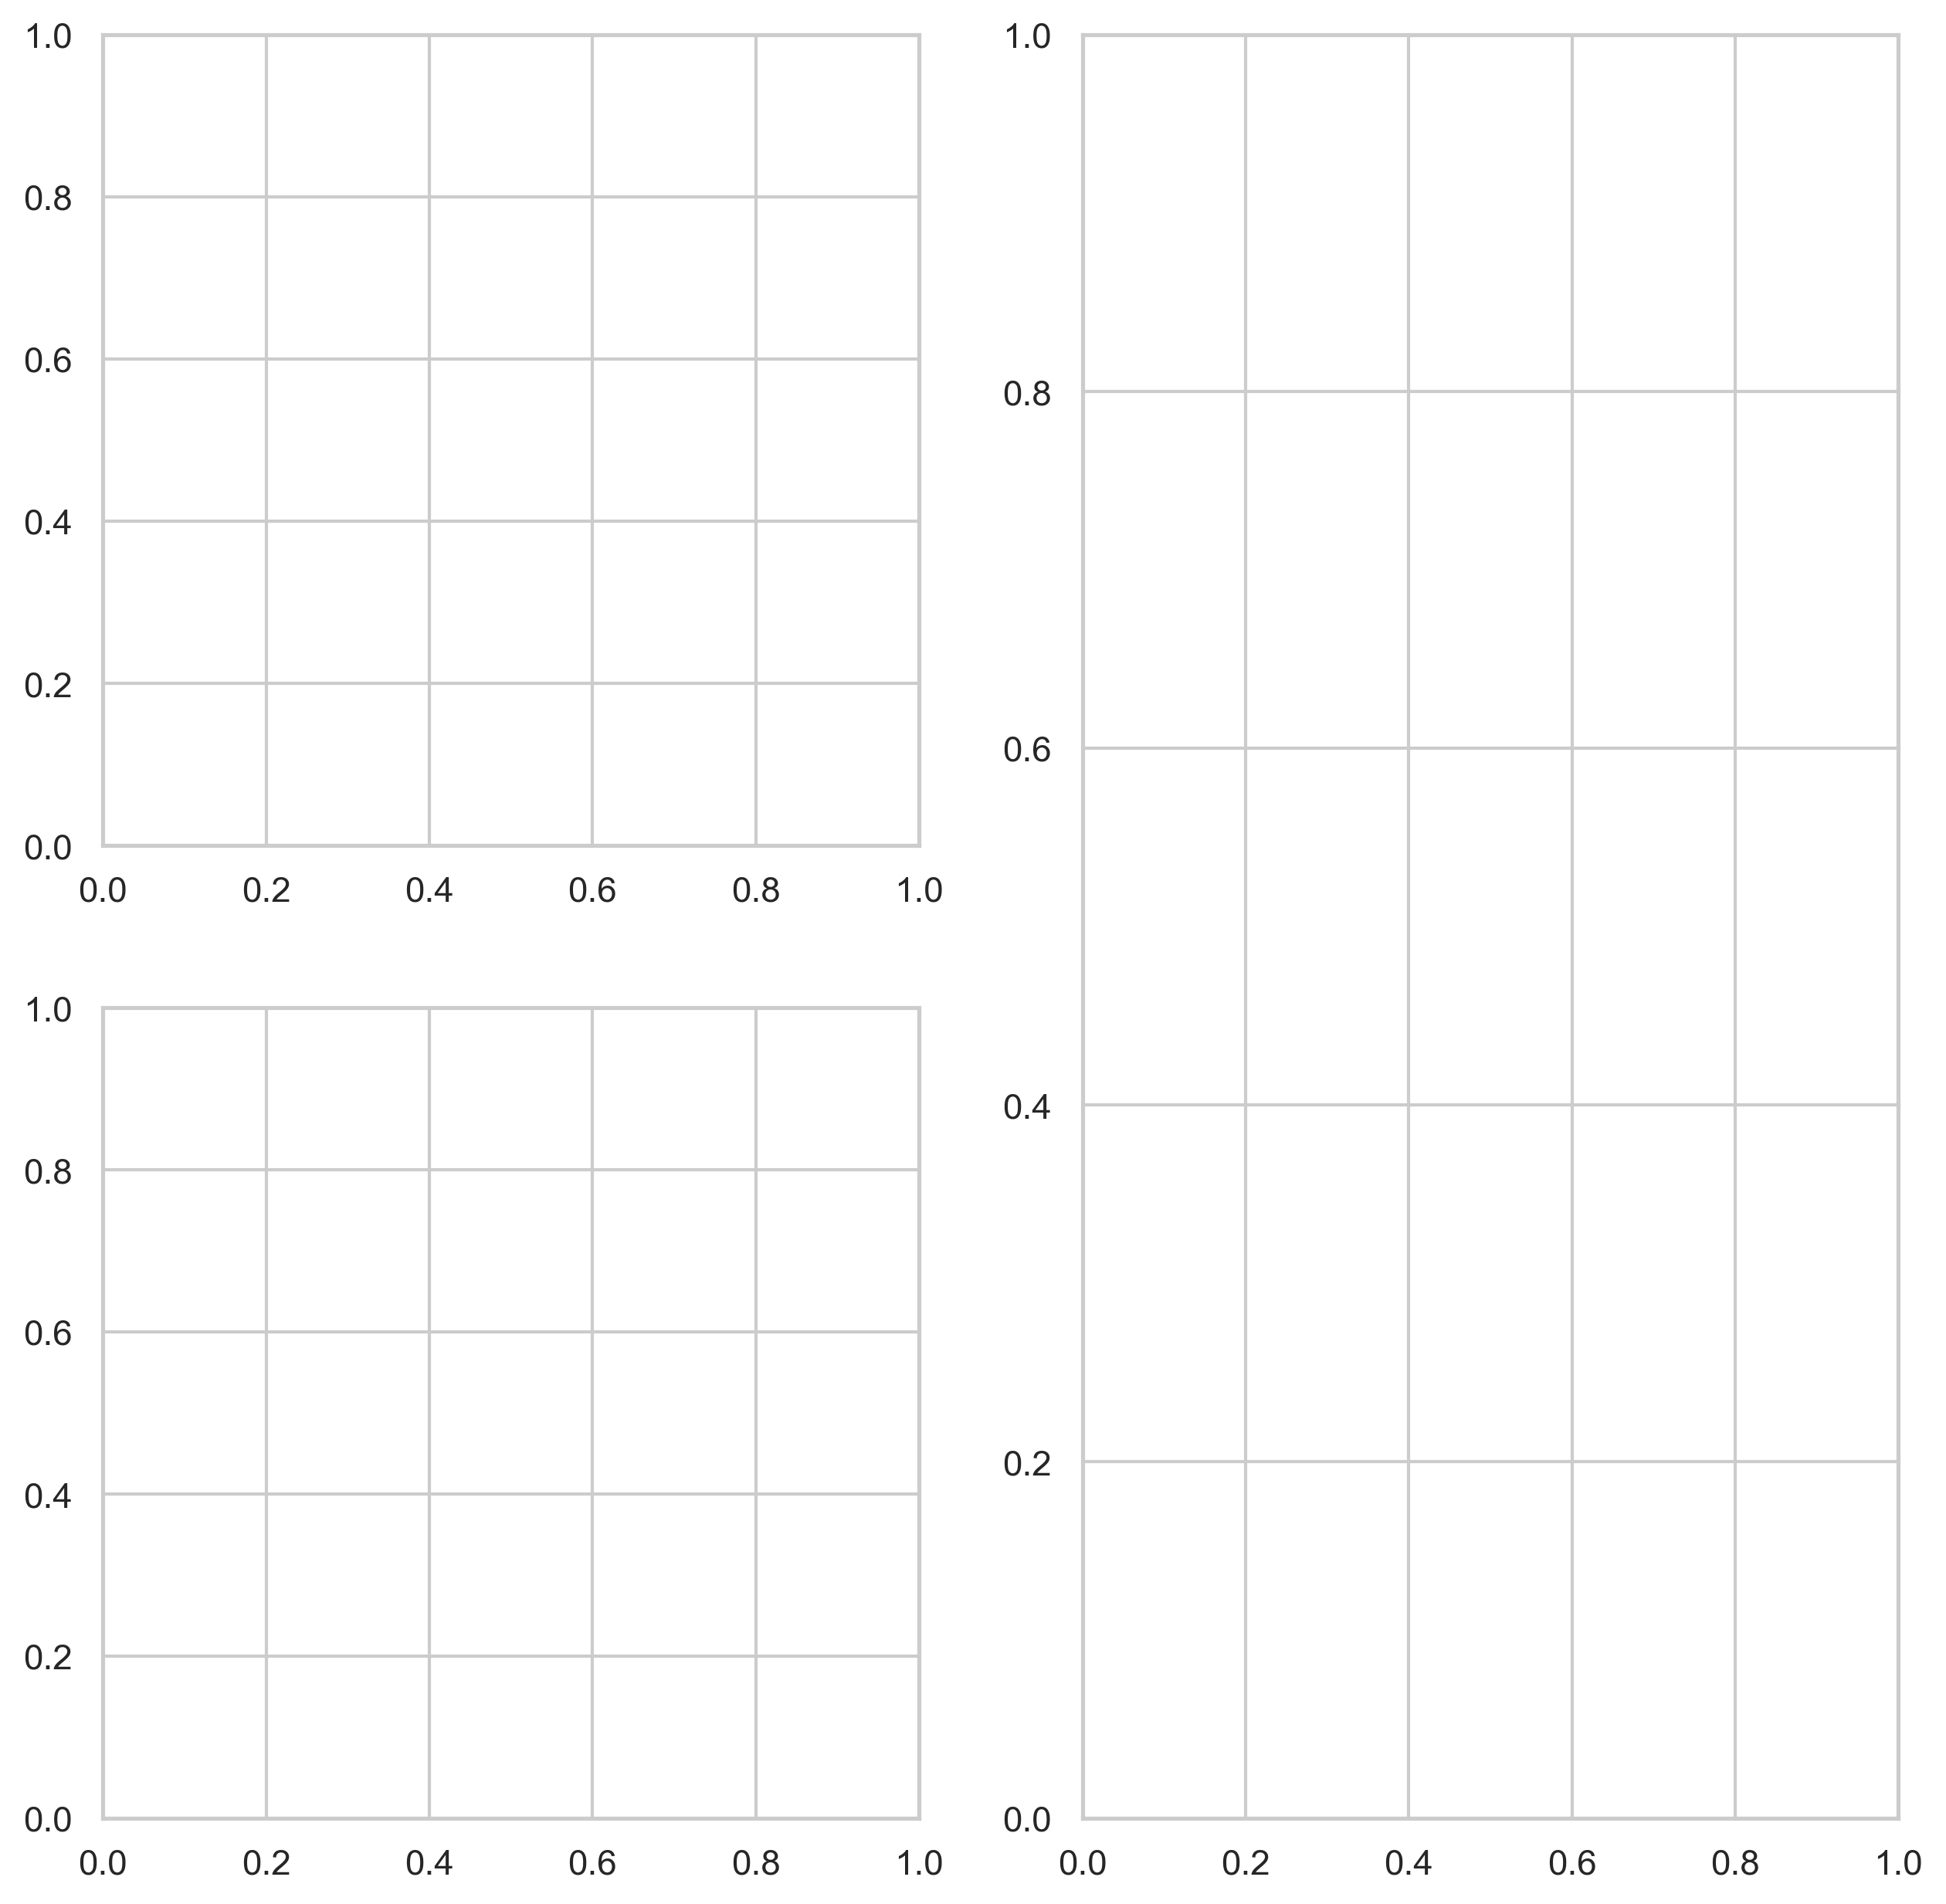

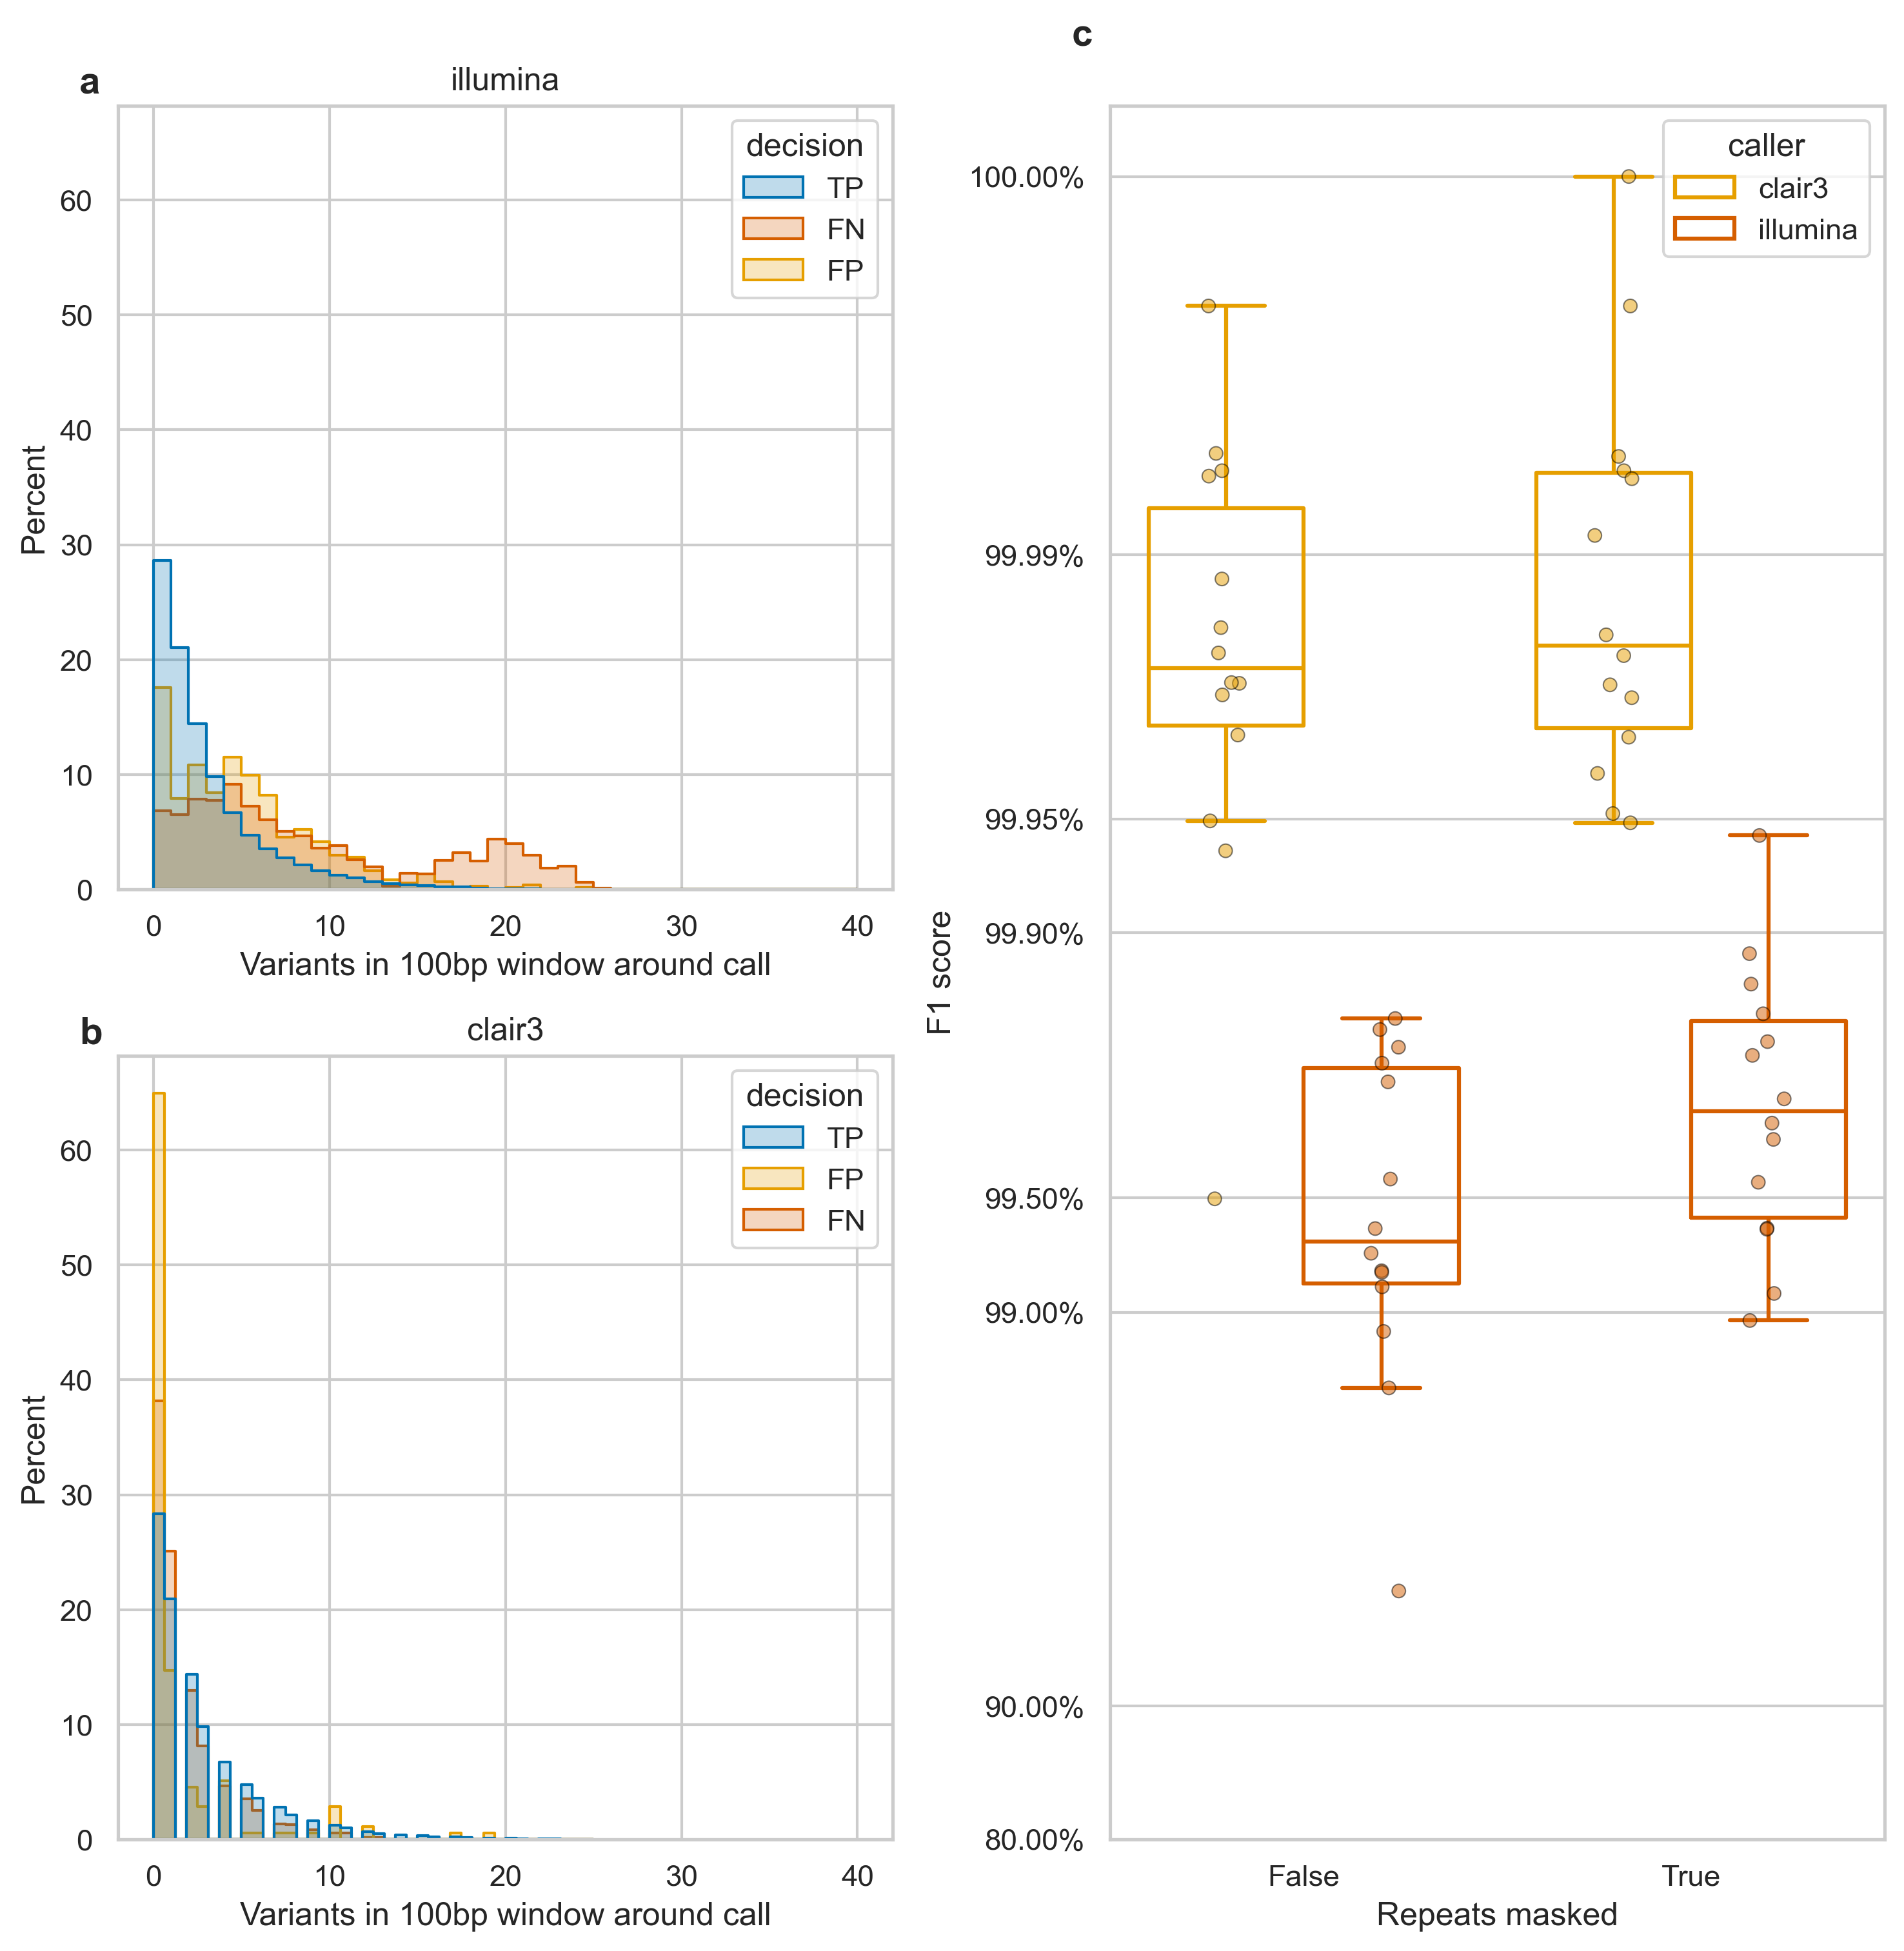

In [501]:
fig = plt.figure(dpi=300, figsize=(10,10))

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0:, -1])

ax1.sharey(ax2)
ax1.sharex(ax2)

for caller, ax in [("illumina", ax1), ("clair3", ax2)]:
    palette = {
        "TP": named_colors["blue"],
        "FP": named_colors["orange"],
        "FN": named_colors["vermilion"],
    }
    if caller == "illumina":
        qry = f"caller == '{caller}'"
    else:
        qry = f"caller == '{caller}' and model != 'fast'"
    data = df.query(qry)
    bins = 40
    sns.histplot(
        data=data,
        x="density",
        hue="decision",
        bins=bins,
        stat="percent",
        common_norm=False,
        element="step",
        # fill=False,
        palette=palette,
        ax=ax,
        legend=True,
    )

    ax.set_title(caller)

    ax.set_xlabel("Variants in 100bp window around call")

hue_order = sorted(set(df["caller"]))
# move illumina to end
hue_order.remove("illumina")
hue_order.append("illumina")
# map each caller in hue order to a colour in cud
palette = {c: cud()[i] for i, c in enumerate(hue_order)}

# vals = []
# x = "density"
# ax = ax3
# for caller in ["illumina", "clair3"]:
#     if caller == "illumina":
#         qry = f"caller == '{caller}'"
#     else:
#         qry = f"caller == '{caller}' and model == 'sup' and mode == 'simplex'"
#     data = df.query(qry)
#     # calculate precision and recall from the decision column with an increasing threshold
#     # on the x column
#     max_dist = 20
#     rng = list(range(0, max_dist+1, 1))

#     recall_denom = data["decision"].value_counts().get("TP", 0) + data["decision"].value_counts().get("FN", 0)

#     for threshold in rng:
#         if threshold >= max_dist:
#             counts = data.query(f"{x} >= {threshold}")["decision"].value_counts()
#         else:
#             counts = data.query(f"{x} == {threshold}")["decision"].value_counts()
#         tp = counts.get("TP", 0)
#         fp = counts.get("FP", 0)
#         fn = counts.get("FN", 0)
#         precision = tp / (tp + fp) if tp + fp > 0 else 1
#         # recall = tp / recall_denom if recall_denom > 0 else 1
#         recall = tp / (tp + fn) if tp + fn > 0 else 1
#         vals.append(
#             {
#                 "caller": caller,
#                 "threshold": threshold,
#                 "metric": "recall",
#                 "value": recall,
#             }
#         )
#         vals.append(
#             {
#                 "caller": caller,
#                 "threshold": threshold,
#                 "metric": "precision",
#                 "value": precision,
#             }
#         )

# pr_df = pd.DataFrame(vals)
cap = 0.99999
# low_cap = 0.001
# pr_df.loc[:, "value"] = pr_df["value"].replace({1: cap})
# pr_df.loc[:, "value"] = pr_df["value"].apply(lambda v: low_cap if v < low_cap else v)
# sns.lineplot(
#     data=pr_df,
#     x="threshold",
#     y="value",
#     hue="caller",
#     ax=ax,
#     palette=palette,
#     style="metric",
#     legend="brief",
# )

# ax.set_yscale("logit", nonpositive="clip")
# yticks = [low_cap, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999, 0.9999, cap]
# yticklabels = [f"{yval:.2%}" if yval > low_cap else "0.00%" for yval in yticks]
# ax.set_yticks(yticks)
# ax.set_yticklabels(yticklabels)
# xticks = rng[::2]
# ax.set_xticks(xticks)
# xticks[-1] = f"{max_dist}+"
# ax.set_xticklabels(xticks)

# ax.set_xlabel("Variants in 100bp window around call")

ax = ax3
vals = []
for b in [True, False]:
    for caller in ["illumina", "clair3"]:
        if caller == "illumina":
            qry = f"caller == '{caller}'"
        else:
            qry = f"caller == '{caller}' and  model == 'sup' and mode == 'simplex'"
        data = df.query(qry)
        threshold = int(b)
        tp = data.query(f"decision == 'TP' and dist >= {threshold}").shape[0]
        fp = data.query(f"decision == 'FP' and dist >= {threshold}").shape[0]
        fn = data.query(f"decision == 'FN' and dist >= {threshold}").shape[0]
        precision = tp / (tp + fp) if tp + fp > 0 else 1
        recall = tp / (tp + fn) if tp + fn > 0 else 1
        vals.append(
            {
                "caller": caller,
                "metric": "recall",
                "value": recall,
                "exclude_repetitive": b,
            }
        )
        vals.append(
            {
                "caller": caller,
                "metric": "precision",
                "value": precision,
                "exclude_repetitive": b,
            }
        )

x = "mask_repeats"
y = "F1_SCORE"
hue = "caller"

best_mask.loc[:, y] = best_mask[y].apply(lambda v: cap if v > cap else v)

sns.stripplot(
    data=best_mask,
    x=x,
    y=y,
    hue=hue,
    ax=ax,
    palette=palette,
    dodge=True,
    linewidth=0.5,
    alpha=0.5,
    legend=False,
)
sns.boxplot(
    data=best_mask,
    x=x,
    y=y,
    hue=hue,
    ax=ax,
    palette=palette,
    showfliers=False,
    dodge=True,
    fill=False,
)

ax.set_ylabel("F1 score")
ax.set_yscale("logit")
yticks = [0.8, 0.9, 0.99, 0.995, 0.999, 0.9995, 0.9999, cap]
yticklabels = [f"{yval:.2%}" for yval in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_xlabel("Repeats masked")


fig.tight_layout()
# add a, b, c, d labels
for i, ax in enumerate([ax1, ax2, ax3]):
    ax.text(
        -0.05,
        1.05,
        chr(97 + i),
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        va="top",
    )

In [393]:
df.query("vartype == 'INDEL' and homlen>0")

,sample,caller,mode,model,chrom,pos,ref,alt,decision,dist,density,homlen,vartype,indel_len
7,ATCC_10708__202309,bcftools,duplex,fast,chromosome,8864,C,CT,FP,17558,1,2,INDEL,1
12,ATCC_10708__202309,bcftools,duplex,fast,chromosome,10596,G,GA,FP,15826,0,2,INDEL,1
16,ATCC_10708__202309,bcftools,duplex,fast,chromosome,11994,TC,T,FP,14427,0,3,INDEL,1
17,ATCC_10708__202309,bcftools,duplex,fast,chromosome,12056,TC,T,FP,14365,0,4,INDEL,1
19,ATCC_10708__202309,bcftools,duplex,fast,chromosome,12746,TG,T,FP,13675,0,3,INDEL,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7844398,AMtb_1__202402,illumina,NaN,NaN,chromosome,4321714,G,GT,FN,0,1,4,INDEL,1
7844405,AMtb_1__202402,illumina,NaN,NaN,chromosome,4344689,AAGGCGCGGCCGC,A,TP,7330,0,1,INDEL,12
7844413,AMtb_1__202402,illumina,NaN,NaN,chromosome,4364390,A,AC,TP,10667,0,4,INDEL,1
7844422,AMtb_1__202402,illumina,NaN,NaN,chromosome,4377146,CCGGGG,C,TP,23423,0,4,INDEL,5


In [415]:
df.query("vartype=='INDEL' and mode == 'simplex' and decision == 'FP' and caller != 'iilumina'").groupby(["caller", "model", "homlen", "indel_len"]).count()["sample"].max()

2171

In [472]:
from itertools import product

In [481]:
# list of all base substitutions - e.g. A>T
substitions = []
for ref, alt in product("ACGT", repeat=2):
    substitions.append(f"{ref}>{alt}")
substitions = sorted(substitions)

samples = df["sample"].unique()
n_samples = len(samples)
samples = sorted(list(samples))

model_substitutions = dict()
for mode in ["simplex", "duplex"]:
    model_substitutions[mode] = dict()
    for model in ["fast", "hac", "sup"]:
        model_substitutions[mode][model] = dict()
        for sample in samples:
            model_substitutions[mode][model][sample] = dict()
            for substitution in substitions:
                model_substitutions[mode][model][sample][substitution] = 0

# combine the ref and alt columns for snps into ref>alt
df["substitution"] = df["ref"] + ">" + df["alt"]
subst_counts = df.query("vartype == 'SNP'").groupby(["mode", "sample", "model", "substitution"]).count()["chrom"]

In [482]:
for mode, sample, model, sub in subst_counts.index:
    model_substitutions[mode][model][sample][sub] = subst_counts.loc[mode, sample, model, sub]

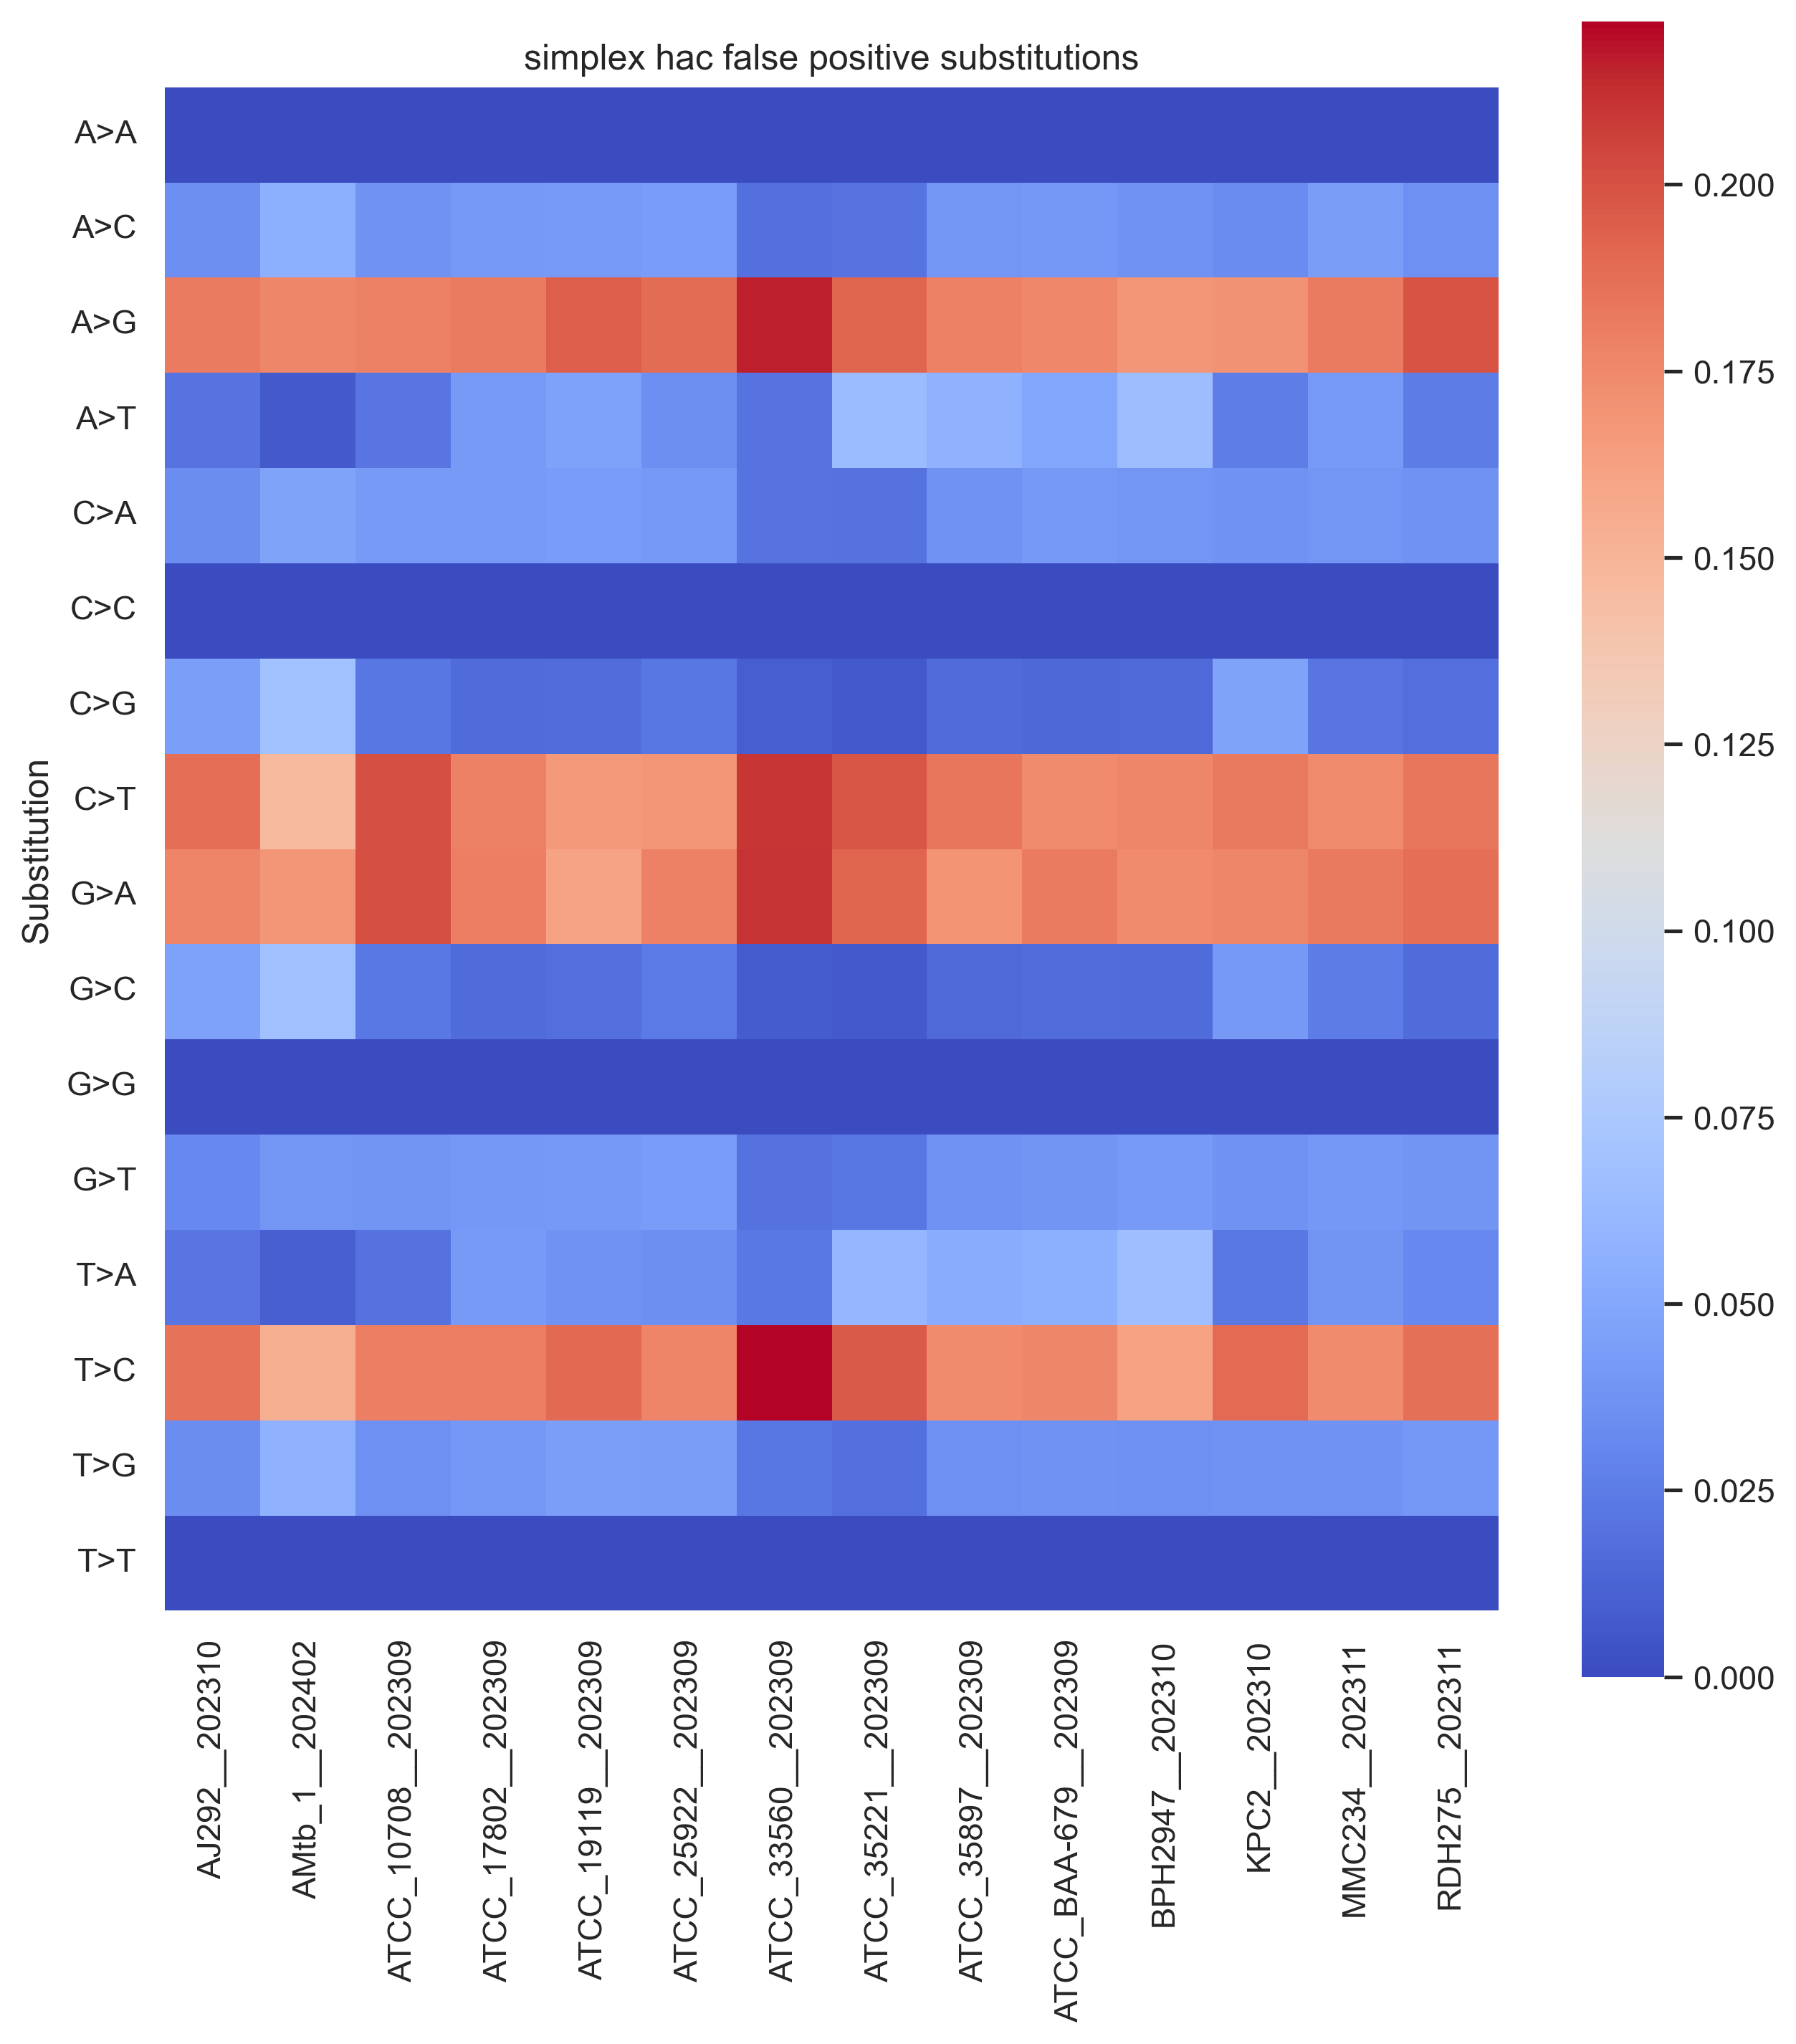

In [493]:
mode = "simplex"
model = "hac"
data = model_substitutions[mode][model]
# turn into pivot so that substitutions are the rows and samples are the columns
data = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
# xticklabels = [
#     samplesheet["species"].loc[sample] for sample in samples
# ]
# make the xticklabels italic
# xticklabels = [f"$\it{{{s.split('_')[0]}}}$ $\it{{{s.split('_')[1]}}}$" for s in xticklabels]
# normalise the counts for each sample (column) to the total number of substitutions
# for that sample
data = data / data.sum()
sns.heatmap(
    data=data,
    # annot=True,
    # fmt="d",
    square=True,
    # xticklabels=xticklabels,
    # yticklabels=substitions,
    ax=ax,
    cmap="coolwarm",
)
ax.set(ylabel="Substitution", title=f"{mode} {model} false positive substitutions")
# rotate yticklabels
for tick in ax.get_yticklabels():
    tick.set_rotation(0)

In [488]:
data

,A>A,A>C,A>G,A>T,C>A,C>C,C>G,C>T,G>A,G>C,G>G,G>T,T>A,T>C,T>G,T>T
AJ292__202310,0,4806,24867,2792,4681,0,6123,25706,24357,6320,0,4363,2962,25436,4716,0
AMtb_1__202402,0,711,2232,90,600,0,876,1861,2137,862,0,505,127,1951,720,0
ATCC_10708__202309,0,4137,20156,2372,4723,0,2474,22634,22649,2602,0,4389,2219,20305,4088,0
ATCC_17802__202309,0,14363,63061,14642,14457,0,5480,62039,62446,5492,0,14012,14561,62913,13984,0
ATCC_19119__202309,0,2151,9862,2361,2162,0,864,8407,8165,906,0,2082,1871,9643,2262,0
ATCC_25922__202309,0,1170,5133,966,1117,0,591,4609,4891,652,0,1170,946,4827,1201,0
ATCC_33560__202309,0,720,8275,793,783,0,342,8059,8087,312,0,733,864,8502,846,0
ATCC_35221__202309,0,2064,19123,6401,1976,0,644,19653,19064,758,0,2206,6062,19547,1886,0
ATCC_35897__202309,0,4055,18180,5884,3878,0,1626,18750,17279,1568,0,3772,5461,17665,3664,0
ATCC_BAA-679__202309,0,2190,9557,2662,2270,0,792,9465,9902,940,0,2119,3020,9630,2032,0


In [12]:
def plot_fp_heatmaps():
    for caller in df["caller"].unique():
        print(caller)
        # create a heatmap of the indel_len vs. homlen columns

        # set vmin and vmax to the min and max of the number of FP variants
        vmax = (
            df.query(
                "vartype=='INDEL' and mode == 'simplex' and decision == 'FP' and caller == @caller"
            )
            .groupby(["caller", "model", "homlen", "indel_len"])
            .count()["sample"]
            .max()
        )

        fig, axes = plt.subplots(figsize=(10, 10), dpi=300, nrows=2, ncols=2)
        cbar_ax = fig.add_axes([1.0, 0.1, 0.03, 0.8])
        for i, model in enumerate(["fast", "hac", "sup", "illumina"]):
            ax = axes.flatten()[i]
            if model == "illumina":
                data = df.query("caller == 'illumina'")
            else:
                data = df.query("caller == @caller")
                data = data.query("model == @model and mode == 'simplex'")
            data = data.query("vartype == 'INDEL' and decision == 'FP'")

            # data = data.query(f"homlen >= {HOM_THRESH}")
            x = "indel_len"
            y = "homlen"
            # turn data into a pivot table where the cells are the counts of the number of variants
            # in each bin
            pivot = data.pivot_table(index=x, columns=y, aggfunc="size", fill_value=0)
            total_fps = data.query("decision == 'FP'").shape[0]
            # calculate the percentage of the total number of FP variants in each bin
            # pivot = pivot / total_fps * 100
            # fill in the missing columns and rows
            # max_x = int(pivot.index.max())
            # max_y = int(pivot.columns.max())
            # for j in range(1, max_x + 1):
            #     if j not in pivot.index:
            #         pivot.loc[j] = 0
            # for j in range(1, max_y + 1):
            #     if j not in pivot.columns:
            #         pivot[j] = 0
            pivot.sort_index(axis=0, inplace=True)
            pivot.sort_index(axis=1, inplace=True)

            # create a heatmap of the pivot table
            mask = pivot == 0

            fmt = "d"
            cbar_ticks = [0, 1, 10, 50, 100, 500, 1000, 2000]
            cbar_kws = {
                "ticks": cbar_ticks,
                "format": mticker.FixedFormatter(cbar_ticks),
                "label": "Number of FP variants",
            }
            sns.heatmap(
                pivot,
                ax=ax,
                cmap="coolwarm",
                cbar_kws=cbar_kws,
                cbar_ax=None if i else cbar_ax,
                # square=True,
                # annot=True,
                linecolor="black",
                linewidths=0.5,
                cbar=i == 0,
                fmt=fmt,
                # mask=mask,
                # vmin=vmin,
                # vmax=vmax,
                norm=SymLogNorm(vmax=vmax, linthresh=1),
            )
            ax.set_title(model)
            if i < 2:
                ax.set_xlabel("")
            else:
                ax.set_xlabel("Homopolymer length")
            if i in [1, 3]:
                ax.set_ylabel("")
            else:
                ax.set_ylabel("Indel length")

            # turn off gridlines
            ax.grid(False)

            # add a vertical dashed line at the HOM_THRESH and align to left

            ax.axvline(
                HOM_THRESH - 1,
                color="red",
                linestyle="-",
                snap=True,
                label="Non-homopolymers",
            )
            # fill between 0 and HOM_THRESH
            # ax.fill_between(
            #     [0, HOM_THRESH - 1],
            #     0,
            #     df["indel_len"].max(),
            #     color="red",
            #     alpha=0.1,
            # )

        fig.tight_layout()
        handles, labels = ax.get_legend_handles_labels()
        for h in handles:
            h.set_linewidth(2)
        fig.legend(
            handles=handles, labels=labels, loc="center", fancybox=True, shadow=True
        )
        # outfile = ""
        # for f in snakemake.output.fp_pdfs:
        #     if caller in f:
        #         outfile = f
        #         break
        # if not outfile:
        #     raise ValueError(f"Could not find output file for caller {caller}")

bcftools


/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_12283/2226109340.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


clair3


/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_12283/2226109340.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


deepvariant


/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_12283/2226109340.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


freebayes


/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_12283/2226109340.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


longshot


ValueError: zero-size array to reduction operation fmin which has no identity

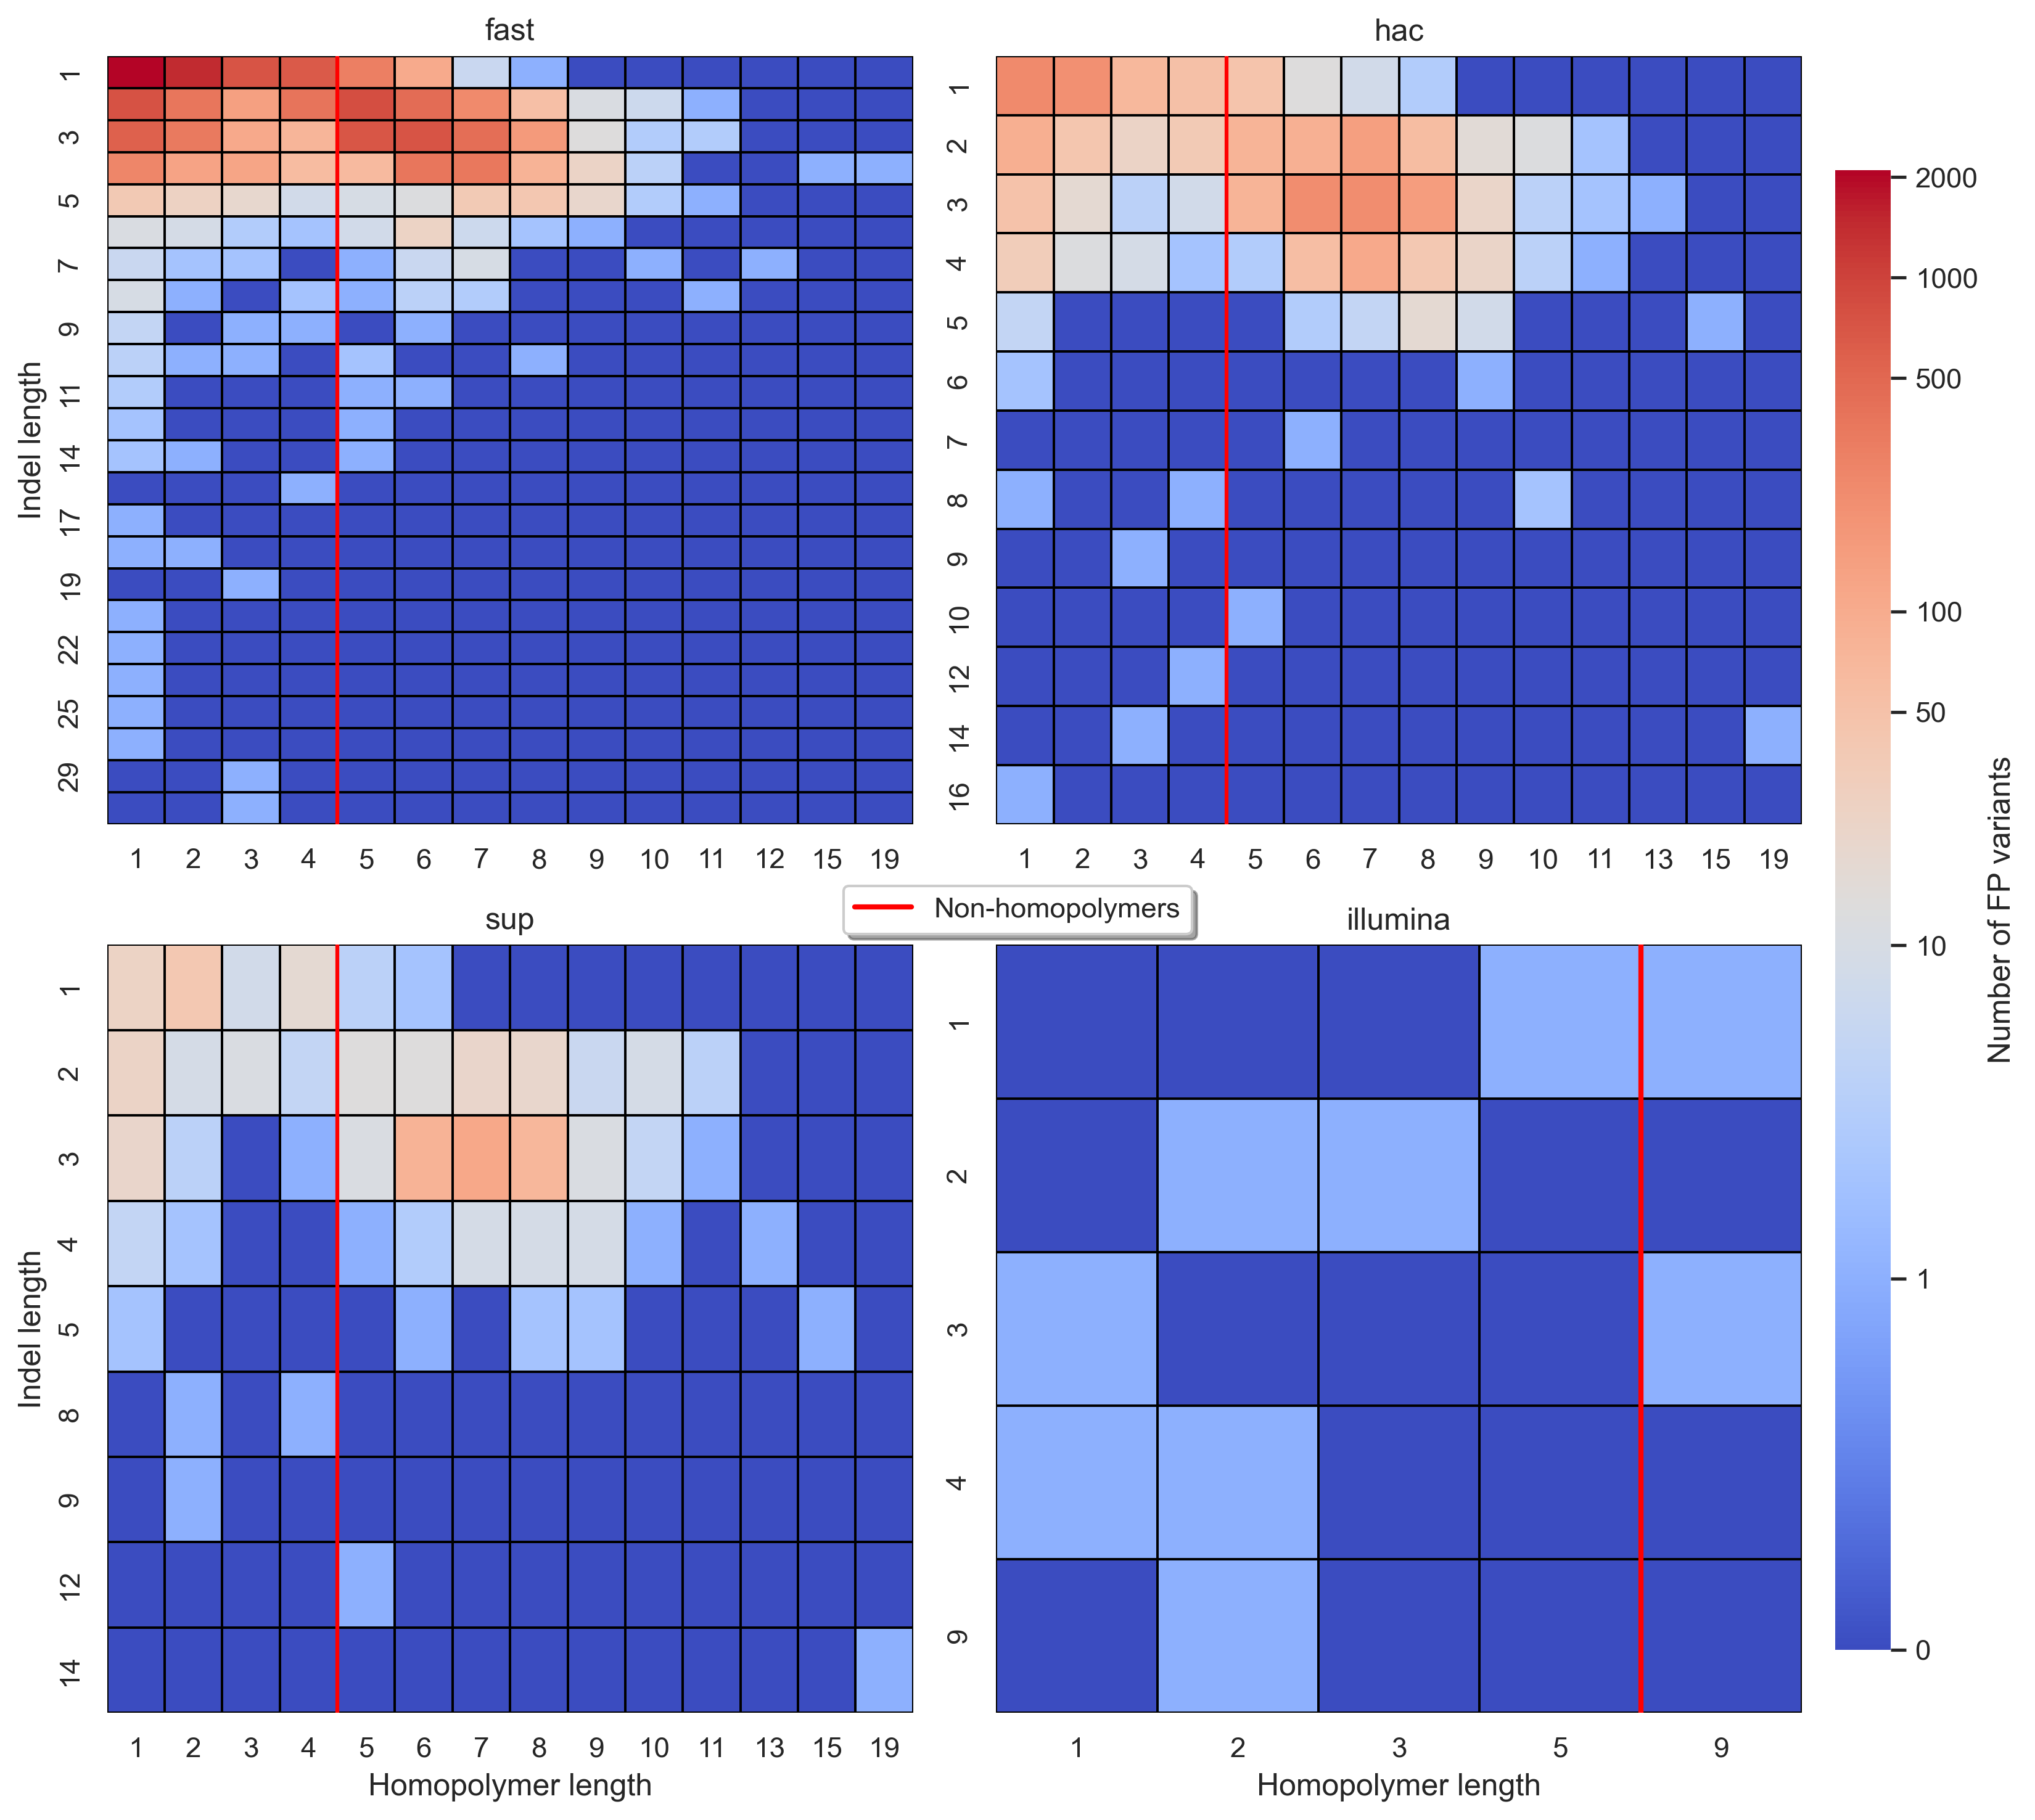

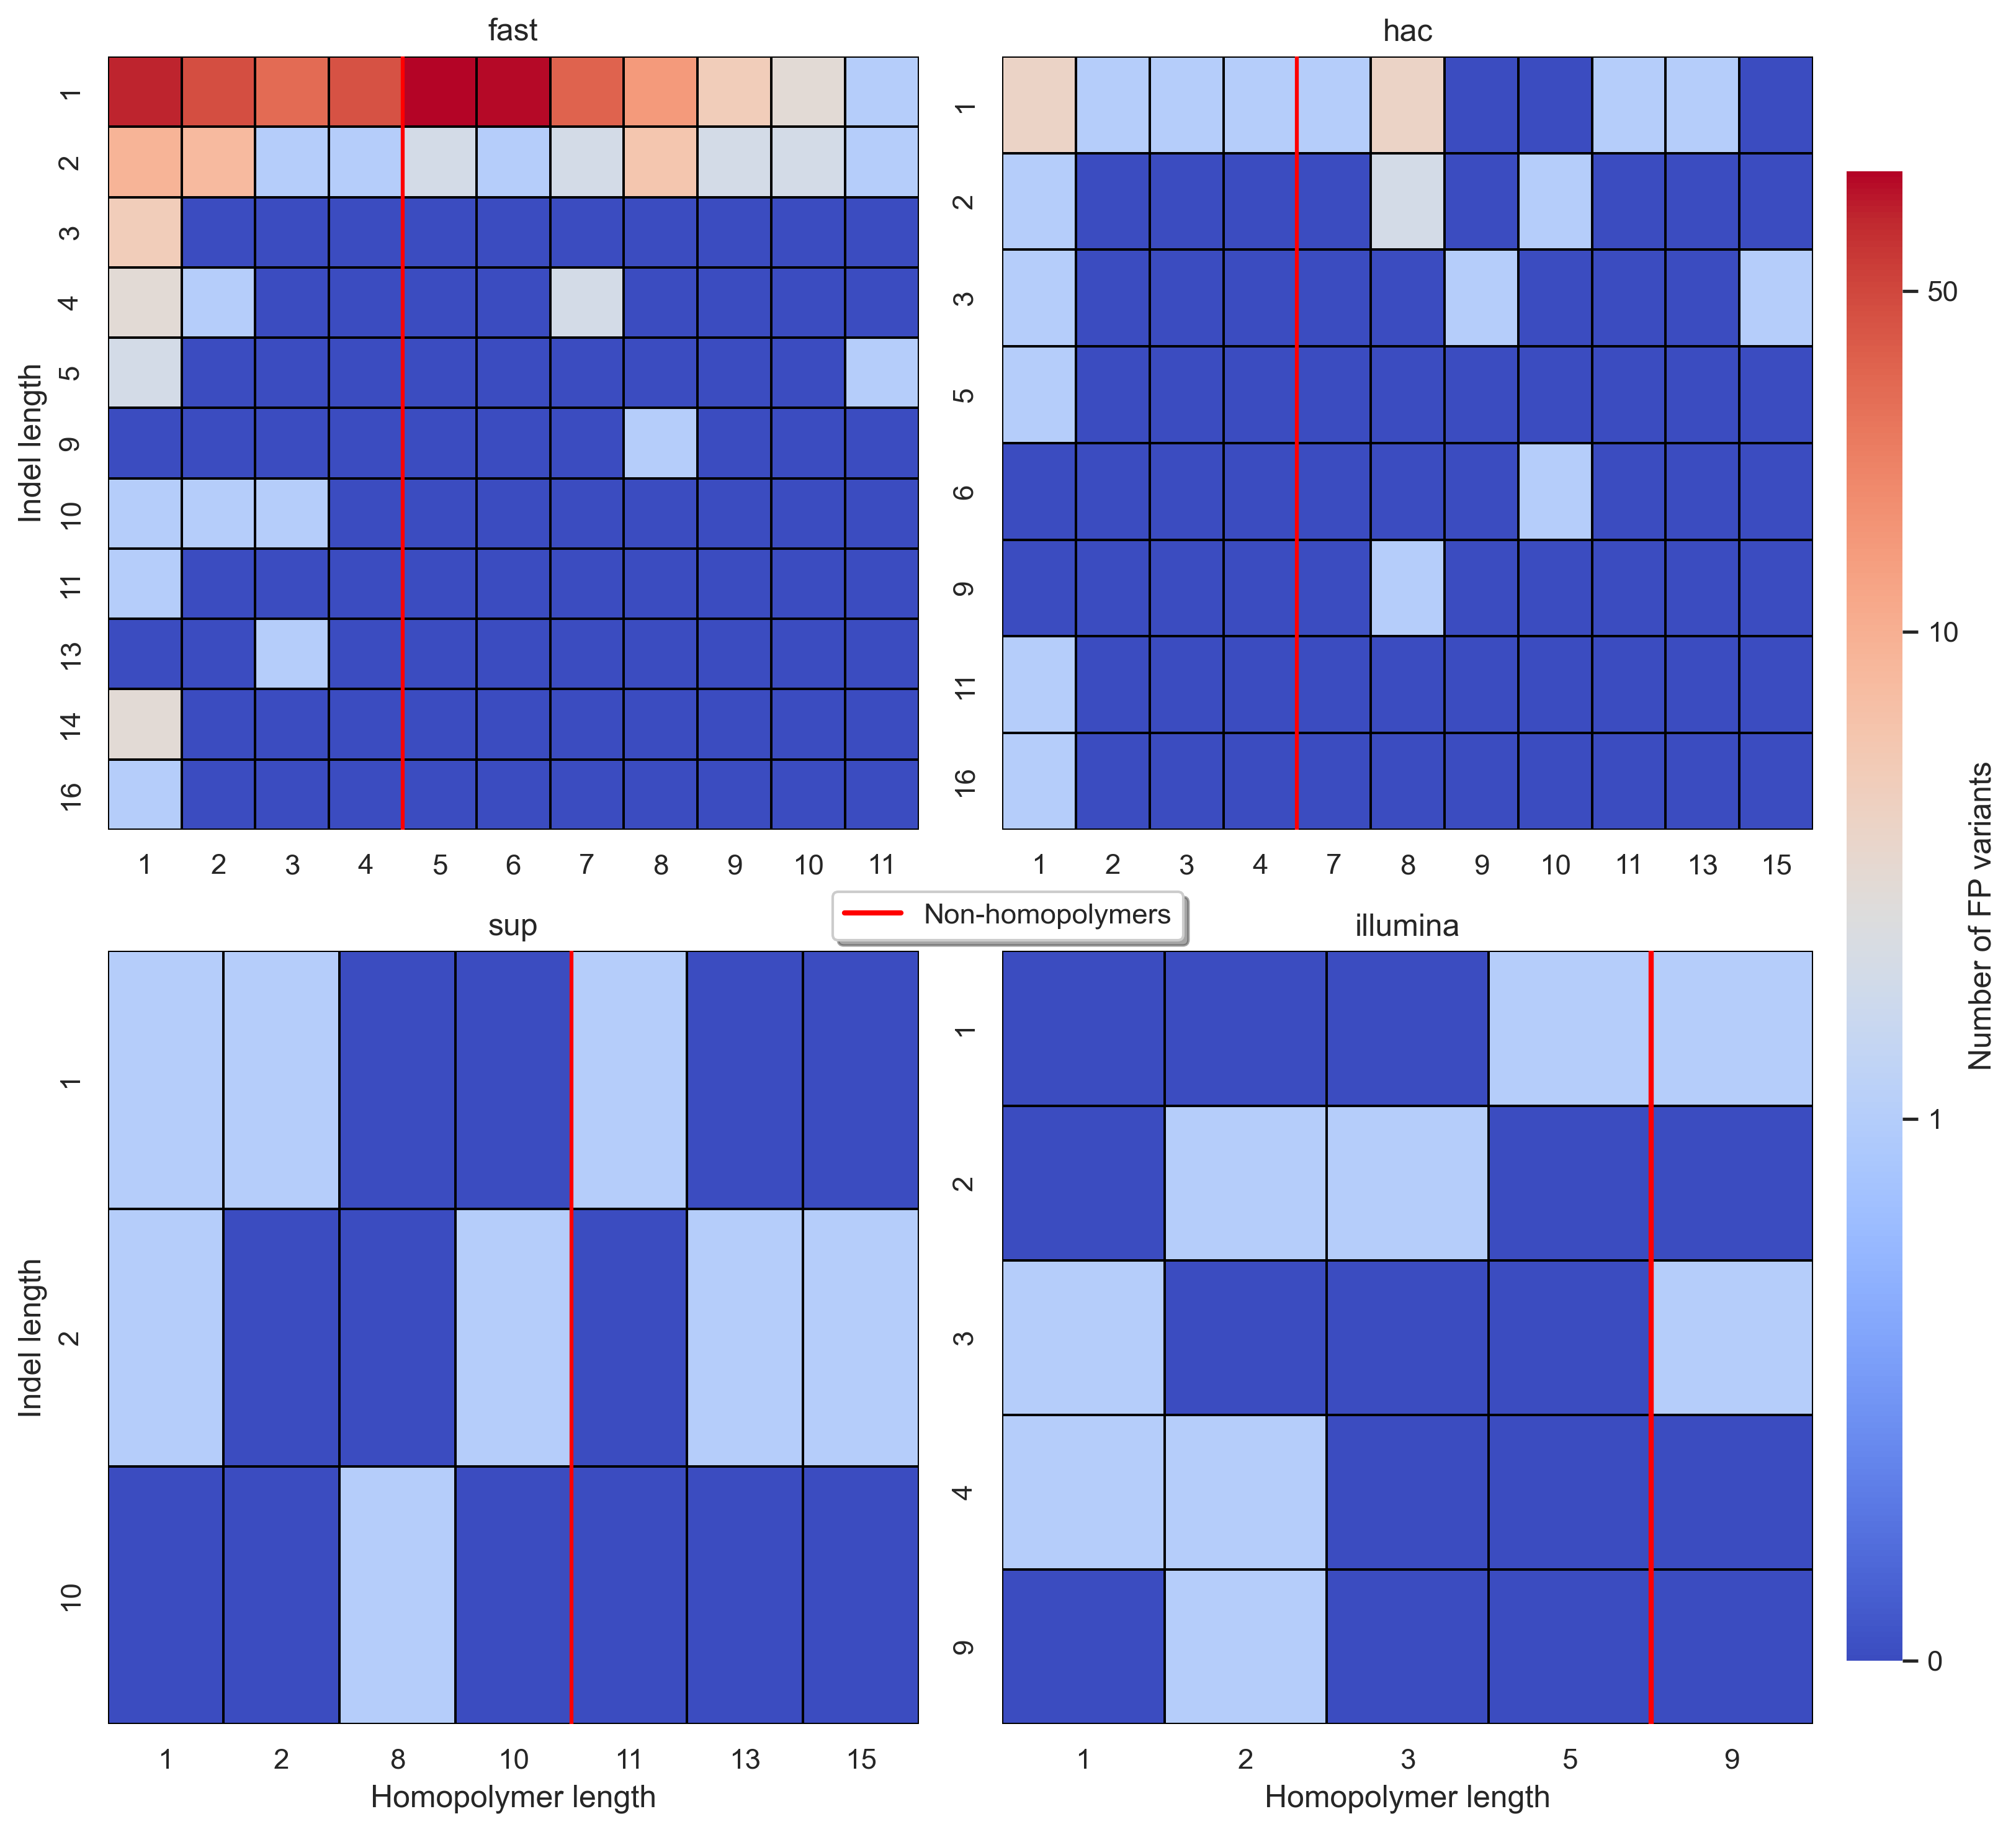

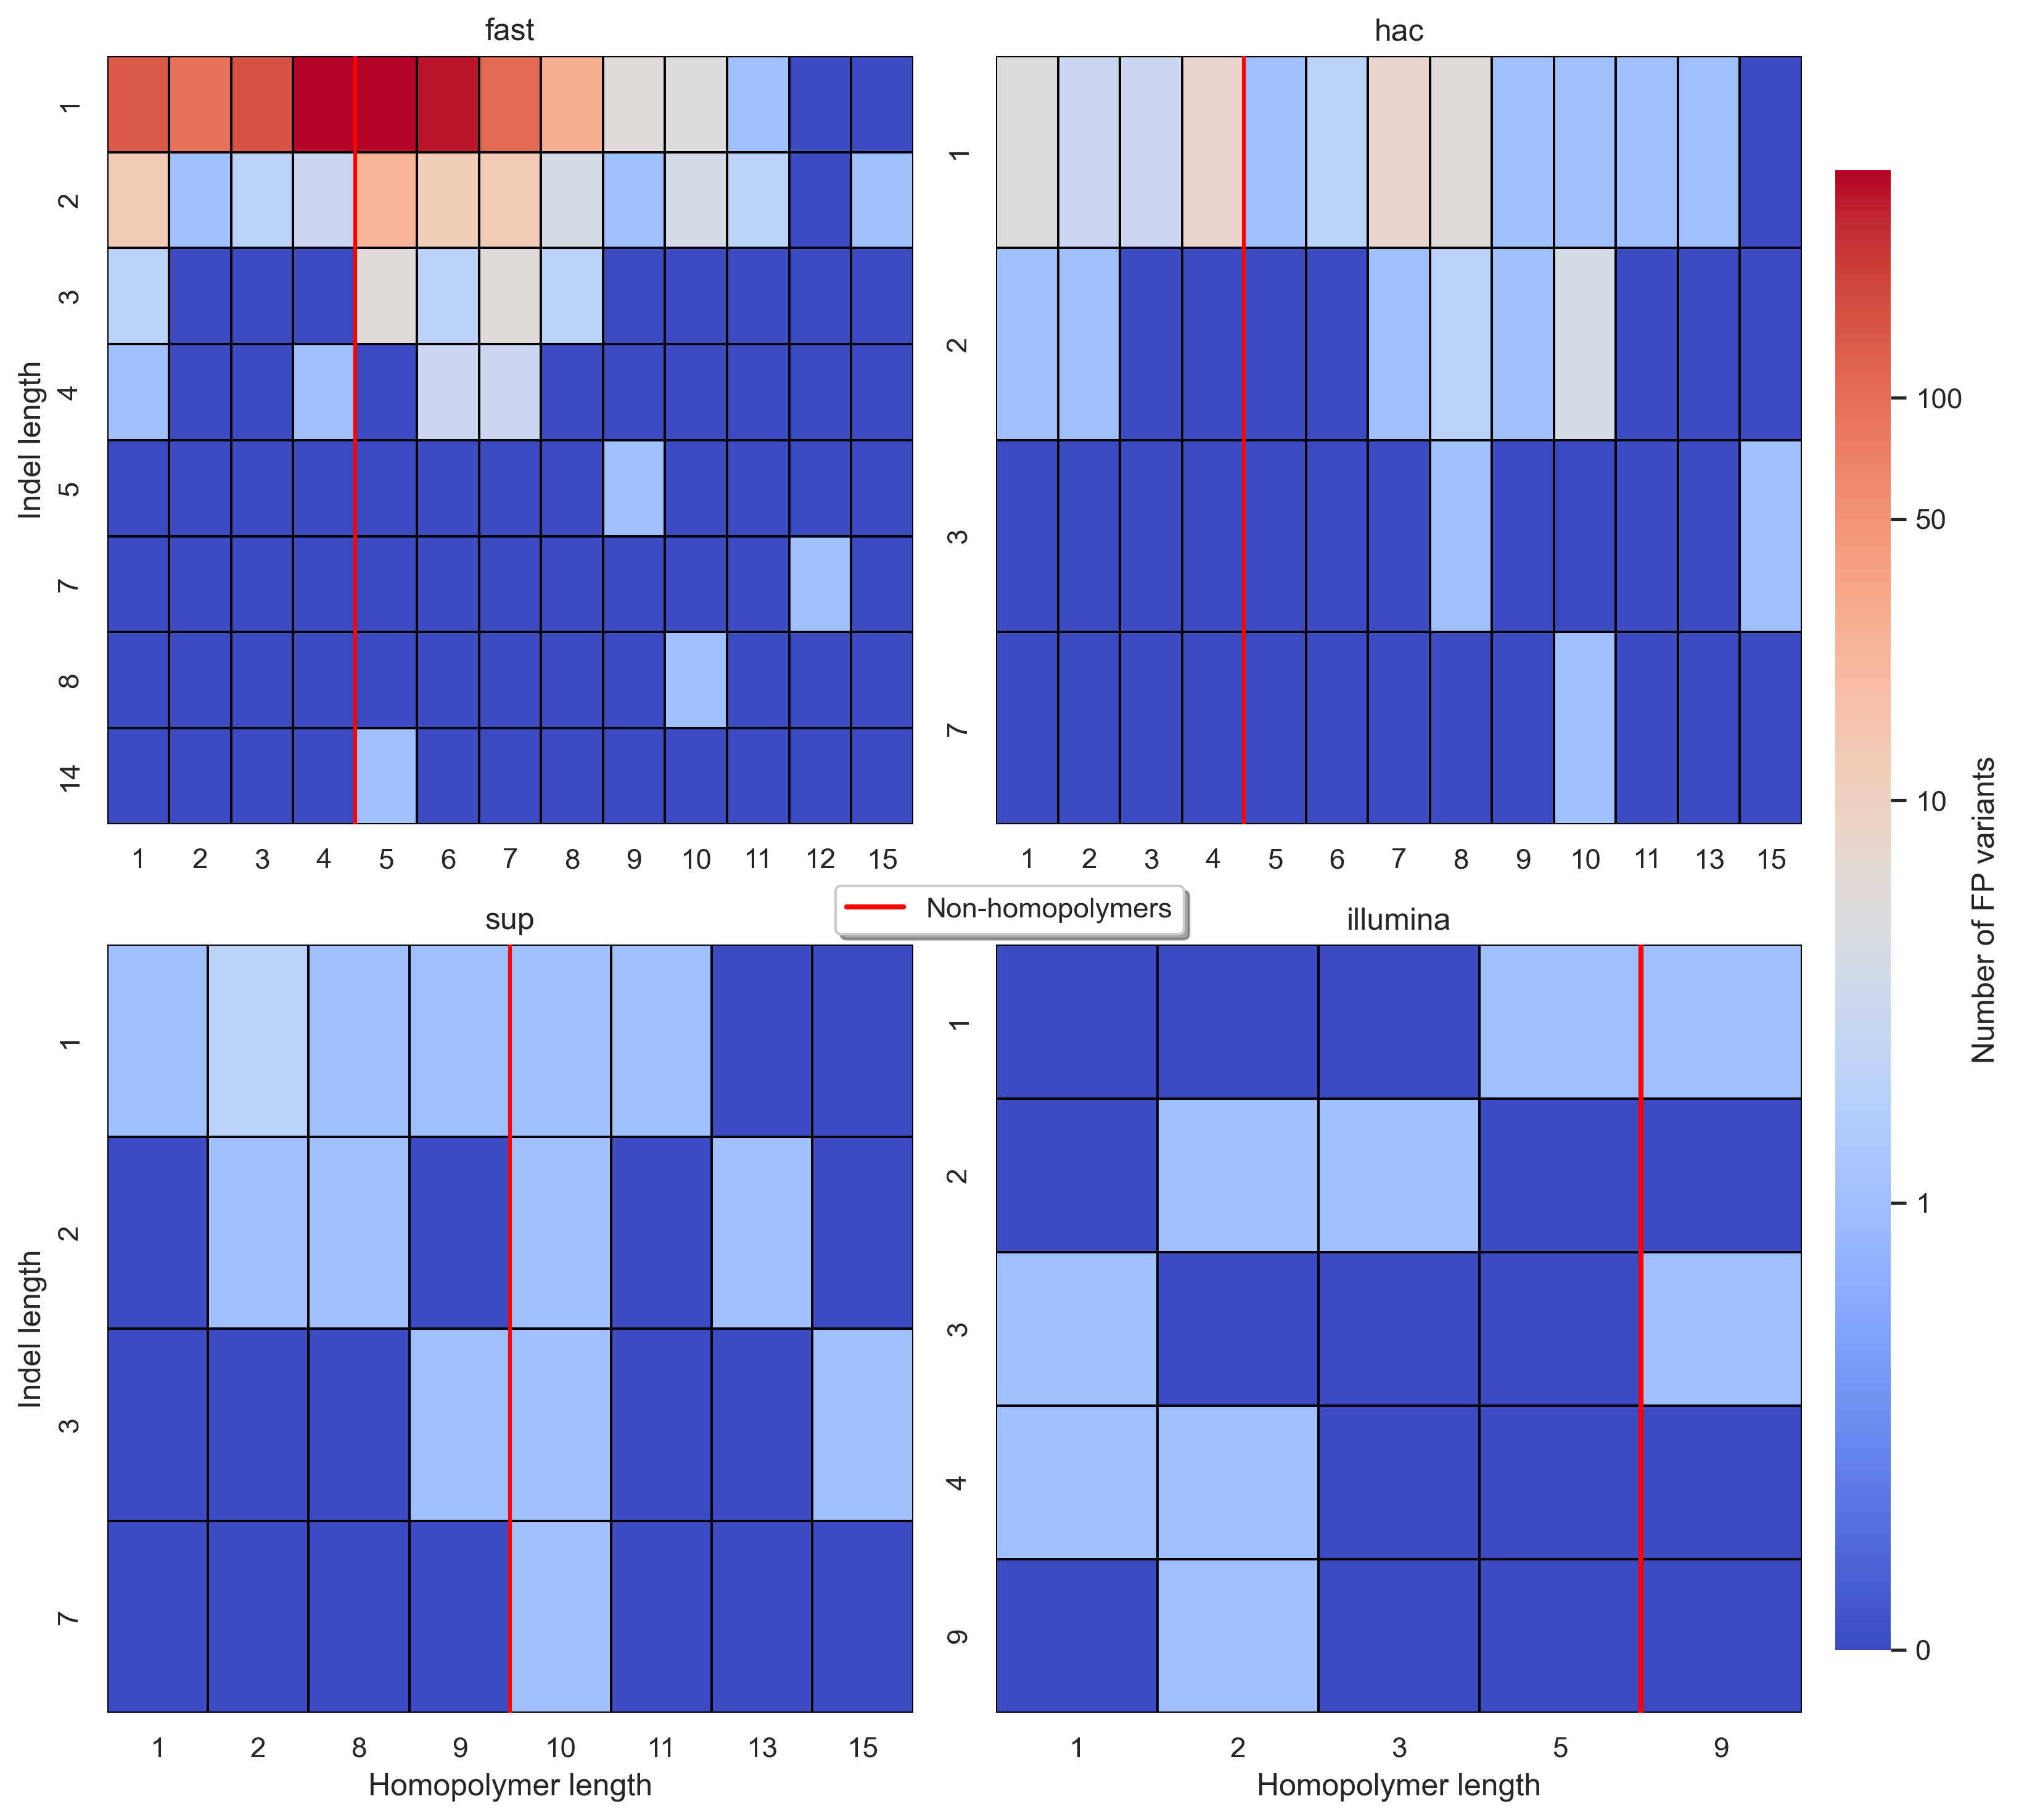

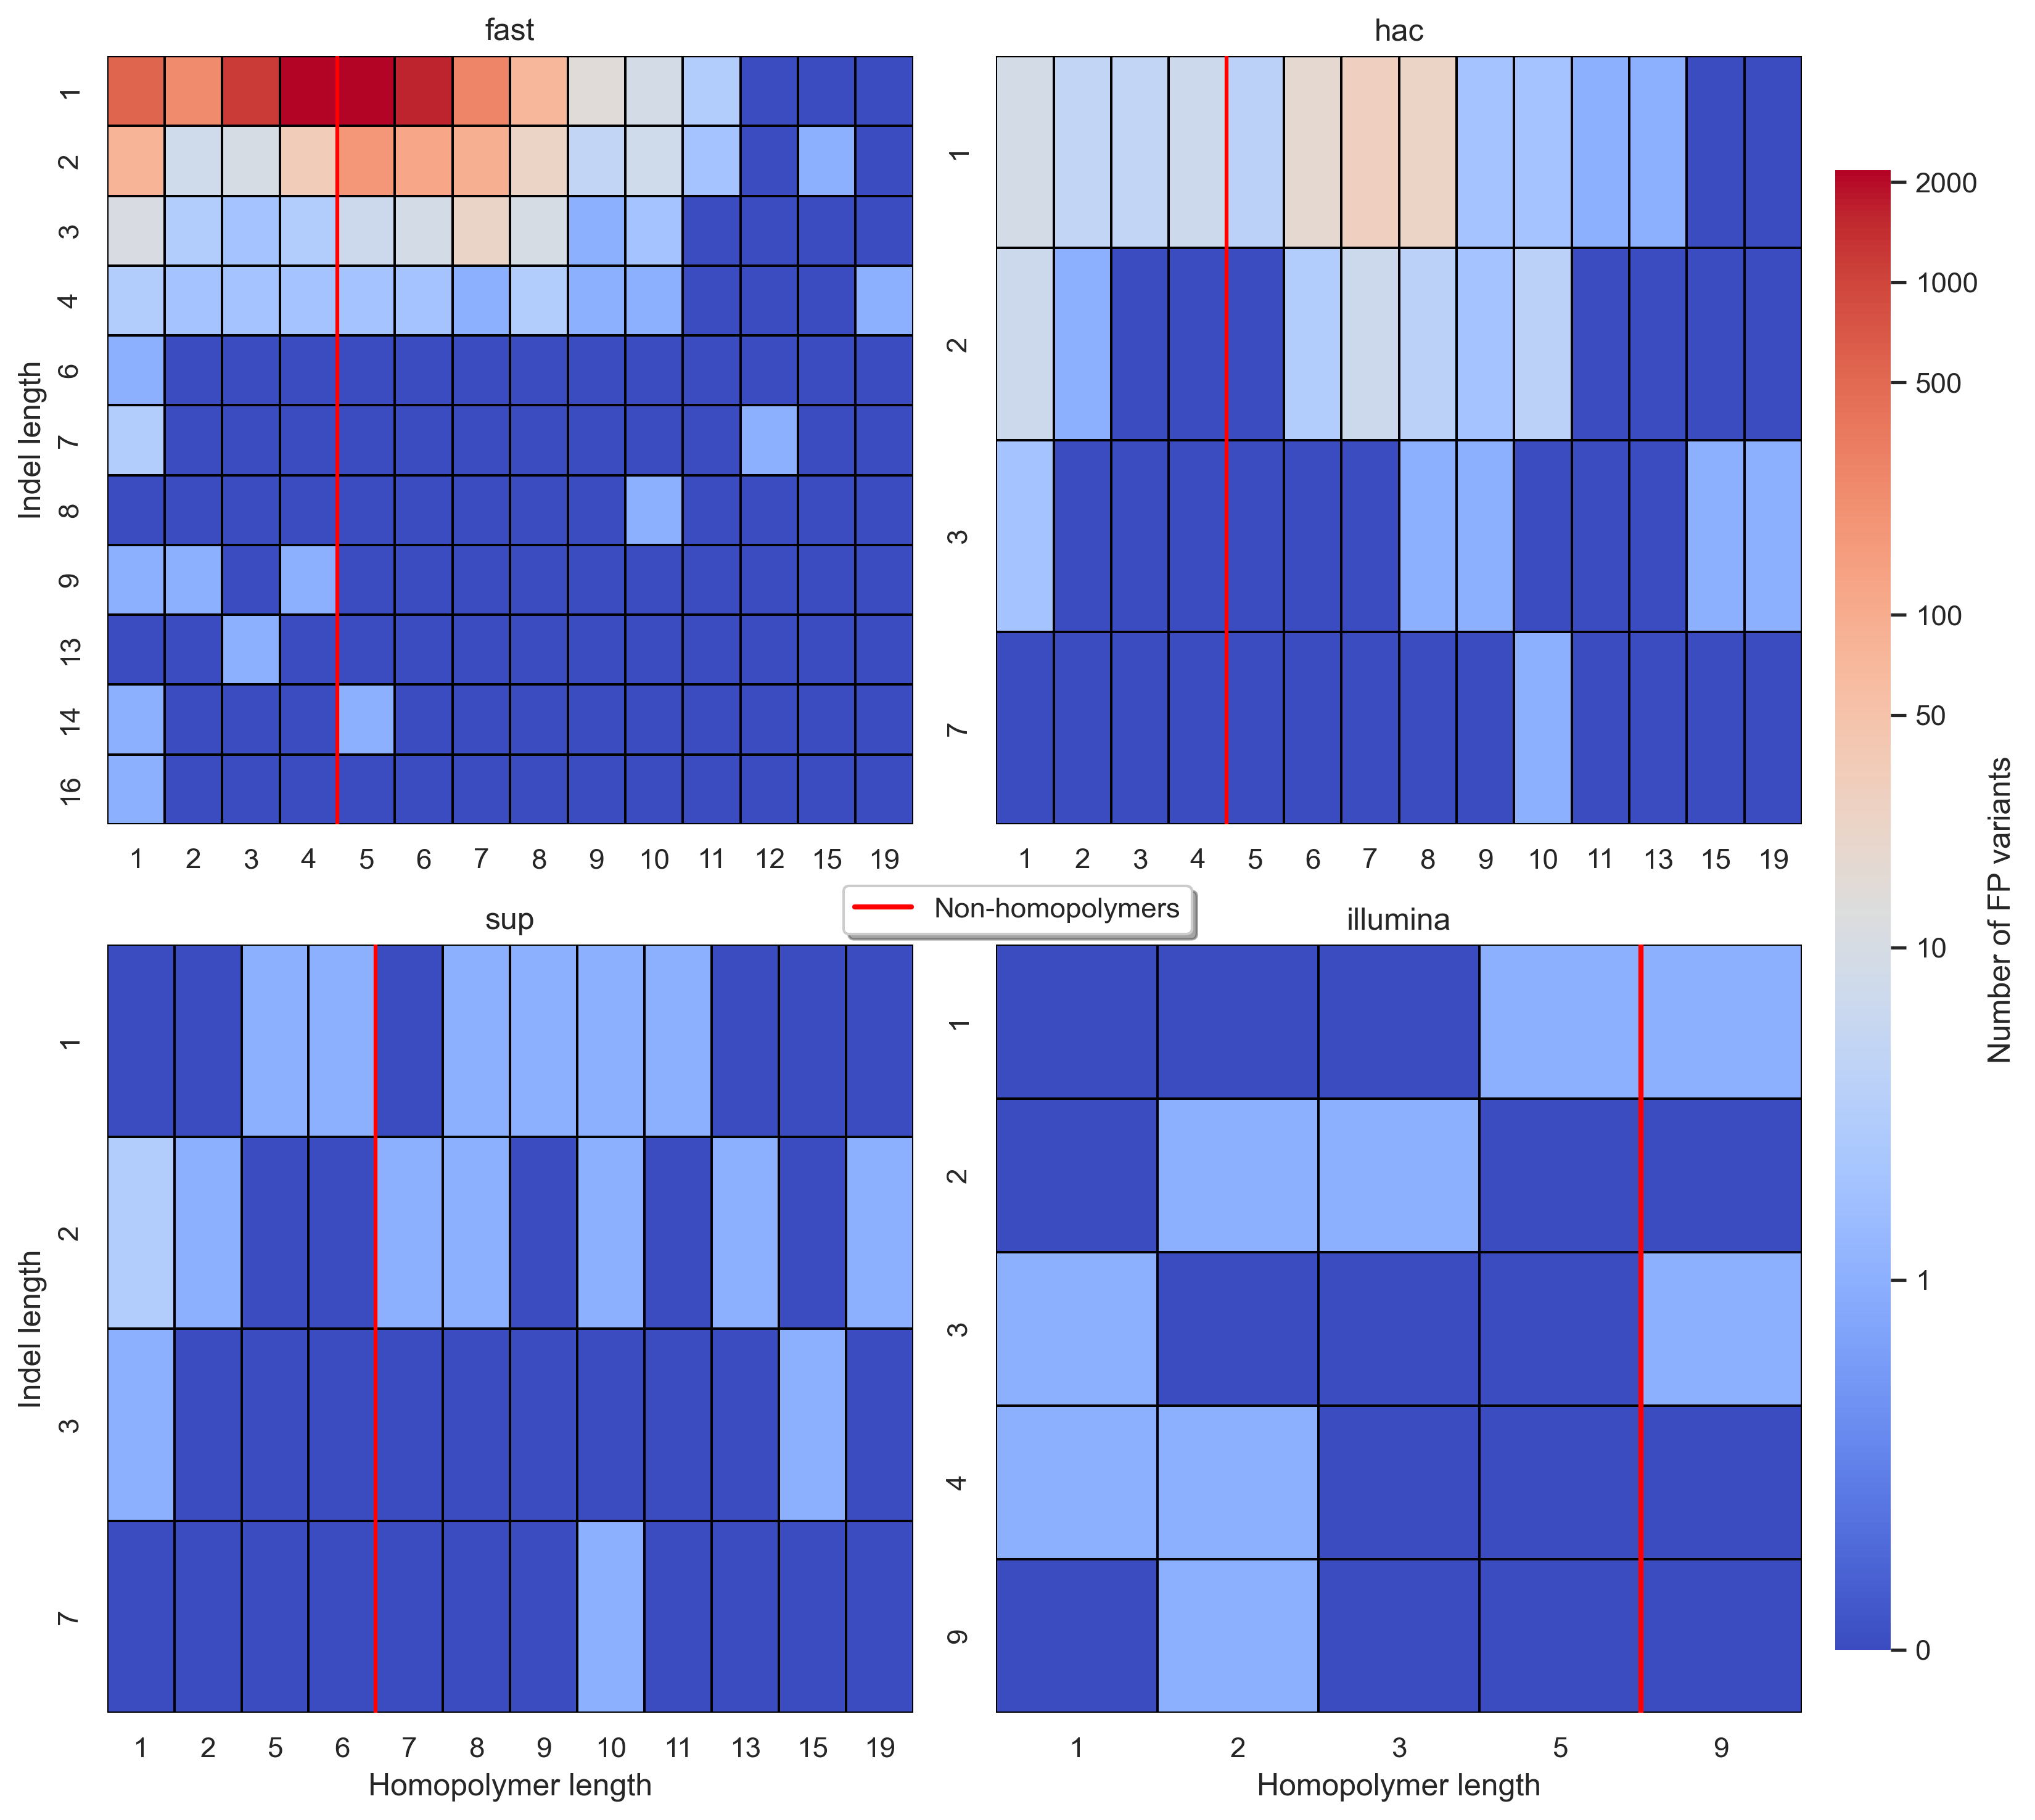

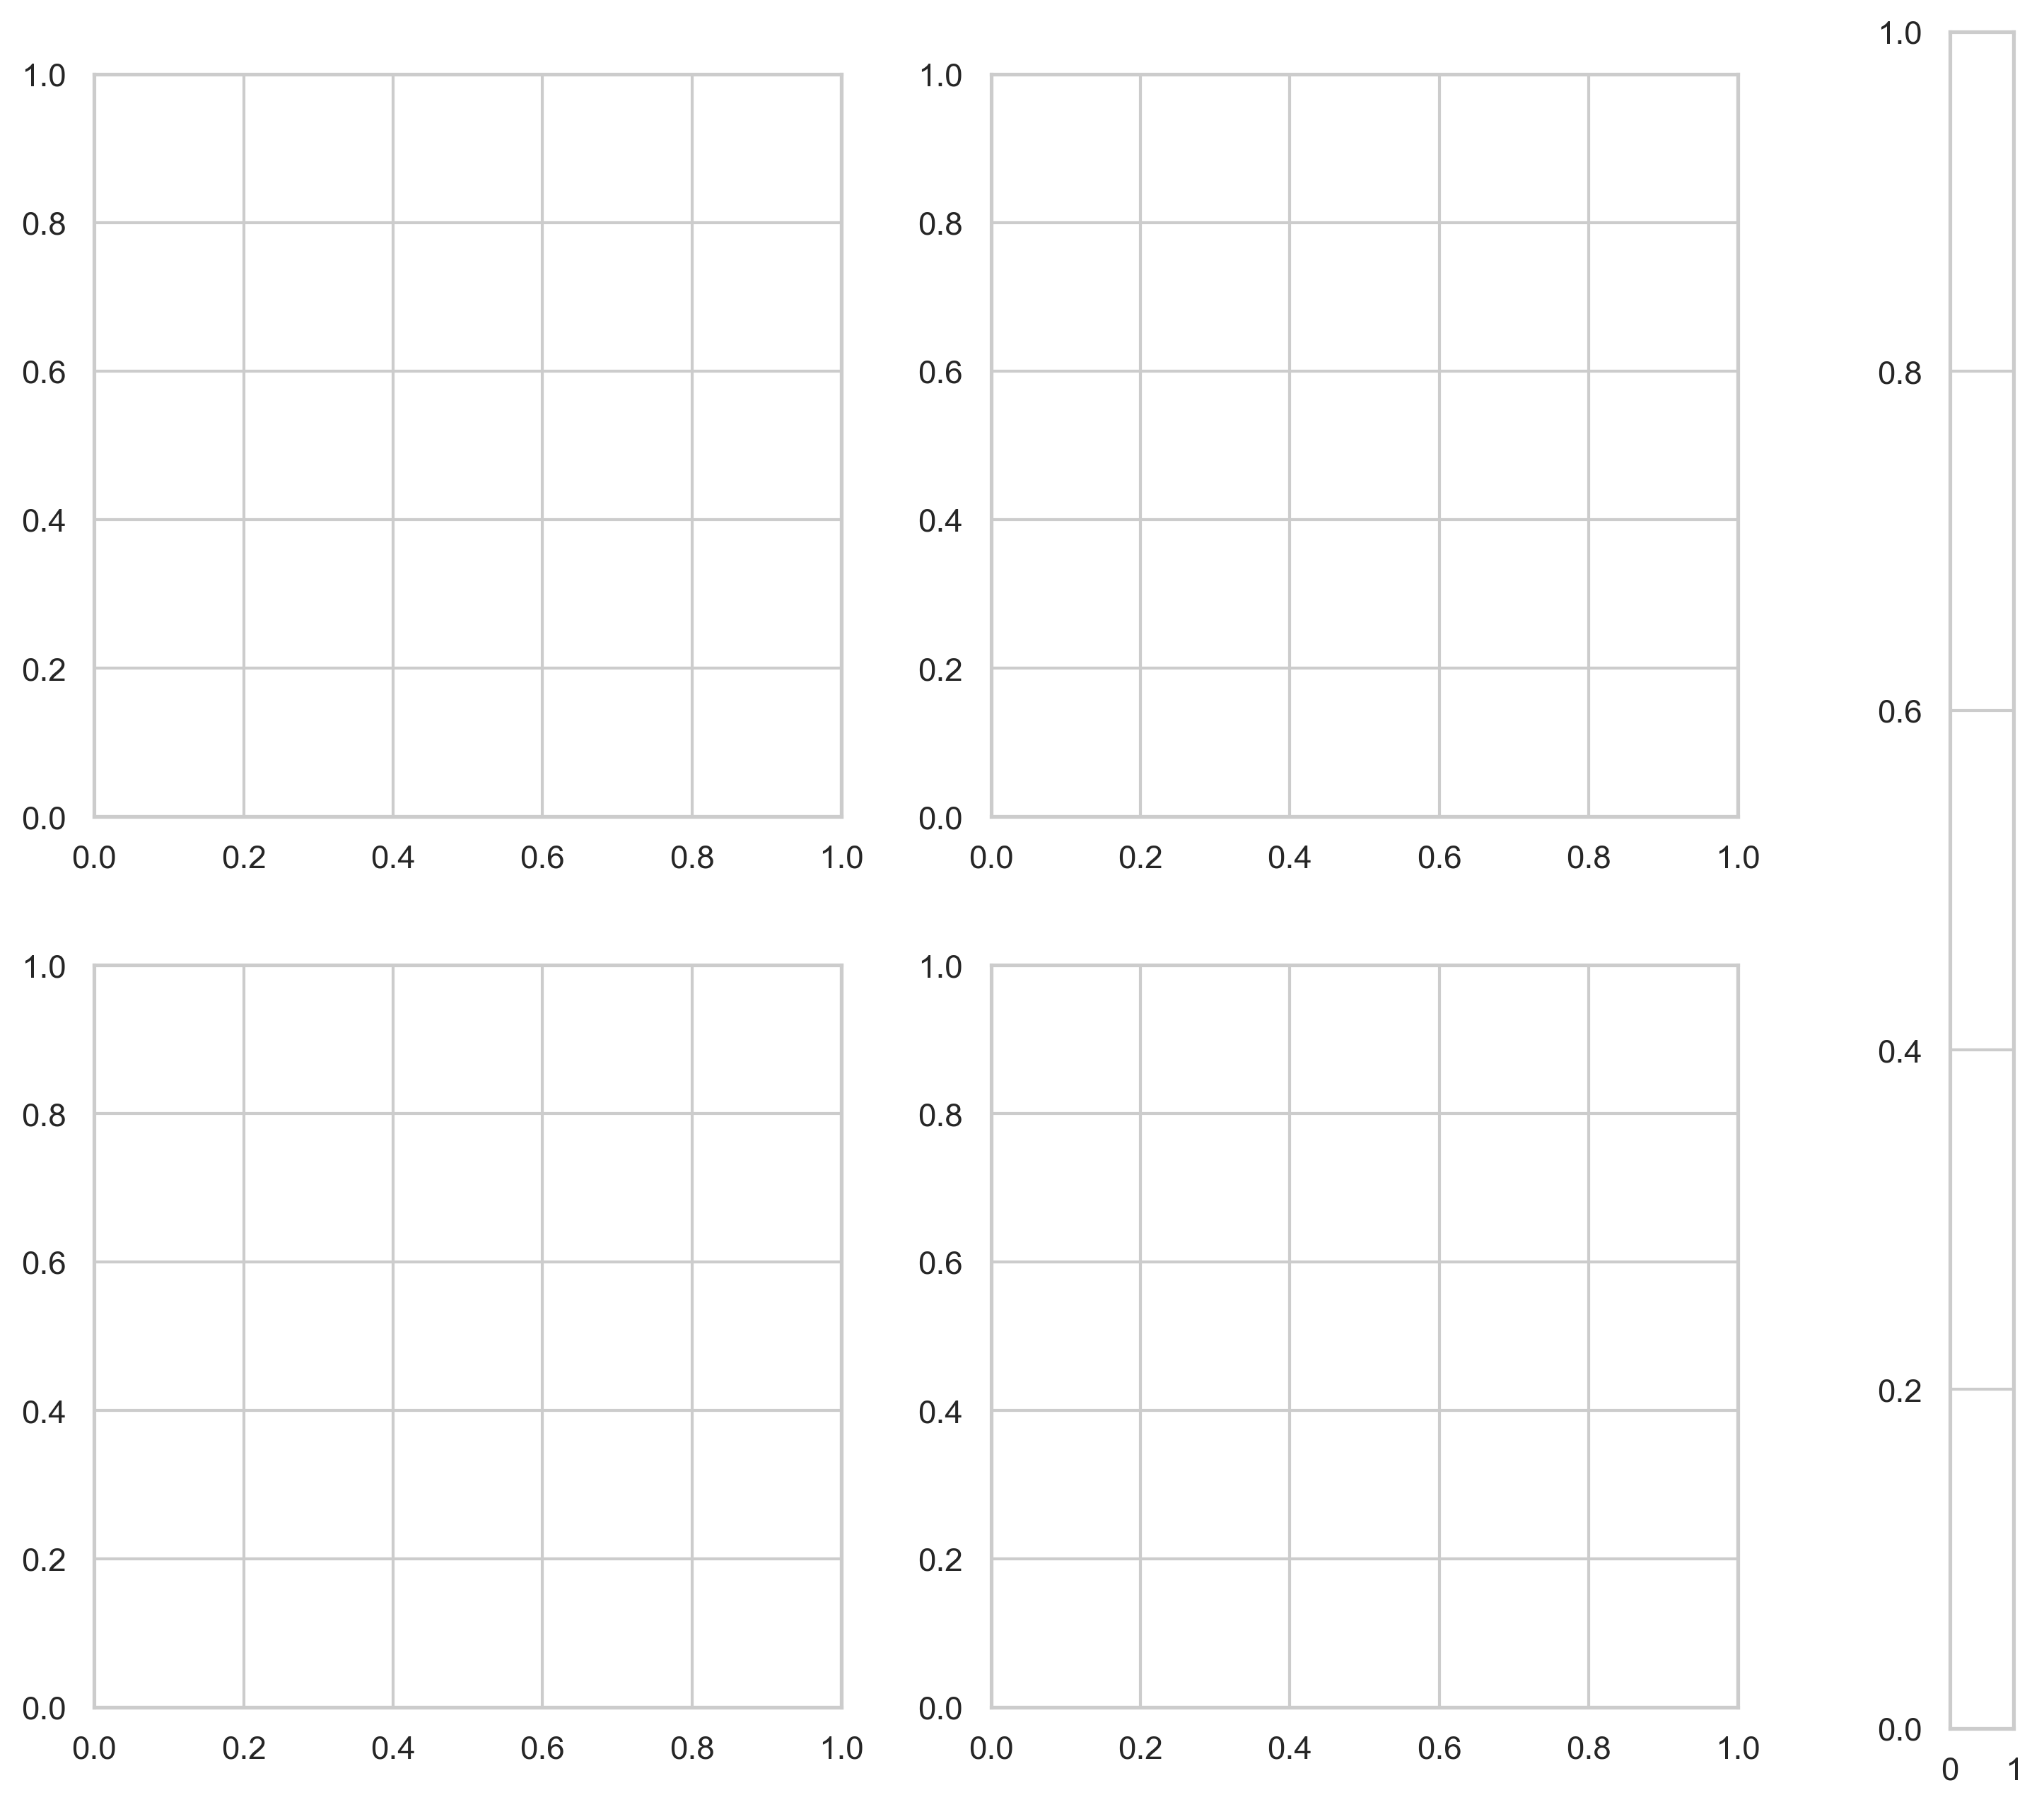

In [13]:
plot_fp_heatmaps()

In [11]:
caller

'freebayes'